# Car Damage Detection with YOLOv11

**Project Goal:**
To build an efficient and accurate computer vision system capable of detecting different types of car damage. This problem is widely relevant in insurance, automotive inspection, and automated claims processing.

**Dataset:**
We use the [CarDD (Car Damage Detection) dataset from Kaggle](https://www.kaggle.com/datasets/issamjebnouni/cardd), which contains labeled images spanning six damage categories:
`dent`, `scratch`, `crack`, `glass_shatter`, `lamp_broken`, and `tire_flat`.

**Methodology Overview:**

1. **Setup & Preparation** – Configure the environment and convert the dataset into the YOLO-compatible format.
2. **Experimentation** – Train multiple **YOLOv11** models with different architectures (`n` vs `s`) and input resolutions (`640px` vs `1024px`) to explore the accuracy–speed trade-off.
3. **Evaluation** – Perform a two-phase evaluation (validation → test set) using metrics such as **mAP**, **precision**, **recall**, and **inference latency** to determine the optimal model.
4. **Deployment** – Package the final chosen model and metadata into a clean, reproducible deployment directory.

---

## 1. Environment Setup

Before training, we verify the hardware and software environment to ensure reproducibility and to make full use of GPU acceleration. This includes confirming the availability of CUDA, checking the PyTorch installation, and validating system diagnostics.

#### GPU and CUDA Check
This command verifies the presence and status of the NVIDIA GPU and CUDA drivers, which are essential for accelerating deep learning model training. The output confirms that a compatible GPU and CUDA version are available.

In [1]:
!nvidia-smi

Wed Dec 10 11:06:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 577.00                 Driver Version: 577.00         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060      WDDM  |   00000000:01:00.0  On |                  N/A |
| 37%   50C    P8            N/A  /  115W |    1062MiB /   8188MiB |     12%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

#### PyTorch and CUDA Availability
This cell confirms that the PyTorch deep learning library is correctly installed and that it can successfully detect and utilize the CUDA-enabled GPU. This is crucial for efficient model training and inference, ensuring all subsequent deep learning operations leverage hardware acceleration.

In [2]:
import torch

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("Device count:", torch.cuda.device_count())
    print("Device name 0:", torch.cuda.get_device_name(0))


Torch version: 2.5.1+cu121
CUDA available: True
Device count: 1
Device name 0: NVIDIA GeForce RTX 4060


### **Setting Reproducibility Seed**

To ensure consistent and repeatable results across runs, we set a fixed random seed (42) for `random`, `numpy`, and `torch`. This controls sources of randomness such as model weight initialization and data shuffling, allowing experimental outcomes to be reproducible and easier to validate.


In [3]:
import random, numpy as np

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Seed set to {seed}")

set_seed(42)


Seed set to 42


## 2. Data Preparation

This section covers the multi-step process of preparing the CarDD dataset for training with YOLOv11.

**Workflow:**

1. **Set up Kaggle API:**  
   A helper function configures the Kaggle API token so the dataset can be downloaded programmatically.

2. **Download Raw Data:**  
   The CarDD dataset is downloaded and unzipped into `datasets/cardd_raw/`. This directory keeps the original, untouched data.

3. **Restructure for YOLO:**  
   The raw `train`, `val`, and `test` folders (containing images and COCO JSON annotations) are copied into a new working directory: `datasets/cardd/`. This becomes the main dataset root for YOLO.

4. **Convert Annotations:**  
   The COCO `.json` files for each split (`train`, `val`, `test`) are parsed, and each bounding box is converted from `[x, y, width, height]` into YOLO format:  
   `class_id x_center_norm y_center_norm width_norm height_norm`.  
   The converted annotations are saved as `.txt` files inside `train/labels`, `val/labels`, and `test/labels`, with one file per image.

5. **Create Dataset YAML:**  
   A `cardd.yaml` configuration file is generated at the project root. It specifies the paths to the `train`, `val`, and `test` image folders and defines the six class names. YOLOv11 uses this file to locate and interpret the dataset during training and evaluation.


In [4]:
import os, json
from pathlib import Path
from getpass import getpass

def setup_kaggle_with_token():
    kaggle_dir = Path.home() / ".kaggle"
    config_path = kaggle_dir / "kaggle.json"

    if config_path.exists():
        print(f"Kaggle credentials already set at: {config_path}")
        return

    KAGGLE_USERNAME = os.environ.get("KAGGLE_USERNAME") or "jeremywijaya"
    KAGGLE_KEY = getpass("Paste your Kaggle API token (KGAT_...): ").strip()

    os.environ["KAGGLE_USERNAME"] = KAGGLE_USERNAME
    os.environ["KAGGLE_KEY"] = KAGGLE_KEY

    kaggle_dir.mkdir(exist_ok=True)
    with open(config_path, "w") as f:
        json.dump({"username": KAGGLE_USERNAME, "key": KAGGLE_KEY}, f)
    try:
        os.chmod(config_path, 0o600)
    except PermissionError:
        pass

    print(f"Kaggle credentials set. Config at: {config_path}")

setup_kaggle_with_token()


Kaggle credentials already set at: C:\Users\Jeremy\.kaggle\kaggle.json


#### Dataset Download and Initial Structure

This cell handles downloading the raw CarDD dataset from Kaggle. It defines the project directories for both the raw data (`cardd_raw`) and the YOLO-formatted dataset (`cardd`). The `if` condition checks whether the dataset already exists to prevent unnecessary re-downloading, ensuring efficient and repeatable notebook runs.

In [5]:
from pathlib import Path

PROJECT_ROOT = Path("..").resolve()
RAW_ROOT = PROJECT_ROOT / "datasets" / "cardd_raw"
YOLO_ROOT = PROJECT_ROOT / "datasets" / "cardd"

RAW_ROOT.mkdir(parents=True, exist_ok=True)

download_dir = str(RAW_ROOT)

if not (RAW_ROOT / "train.json").exists():
    print("Downloading CarDD dataset...")
    !kaggle datasets download -d issamjebnouni/cardd -p "$download_dir" --unzip
    print("✅ Download complete")
else:
    print("CarDD raw dataset already present, skipping download.")


CarDD raw dataset already present, skipping download.


#### Copying and Structuring Data Splits

This step copies the raw dataset’s `train`, `val`, and `test` folders into a new directory (`datasets/cardd`).  
This separation keeps the original downloaded data untouched while preparing a clean, organized structure for YOLOv11.  
The resulting `images/` and `labels/` directories follow the standard YOLO dataset format, making the dataset ready for annotation conversion and training.


In [6]:
import shutil

YOLO_ROOT.mkdir(parents=True, exist_ok=True)

for split in ["train", "val", "test"]:
    src = RAW_ROOT / split
    dst = YOLO_ROOT / split

    if not src.exists():
        print(f"{split}: source {src} not found, skipping.")
        continue

    if dst.exists():
        shutil.rmtree(dst)

    shutil.copytree(src, dst)
    print(f"Copied {split} -> {dst}")

print("Final YOLO root:", YOLO_ROOT.resolve())


Copied train -> C:\dev\final_project_deep_learning\datasets\cardd\train
Copied val -> C:\dev\final_project_deep_learning\datasets\cardd\val
Copied test -> C:\dev\final_project_deep_learning\datasets\cardd\test
Final YOLO root: C:\dev\final_project_deep_learning\datasets\cardd


In [7]:
print(os.listdir("../datasets"))


['cardd', 'cardd_raw']


#### COCO to YOLO Annotation Conversion

This step converts the original COCO-style `.json` annotations into the `.txt` format required by YOLOv11.  
The `build_cat_mapping` function creates a consistent mapping from COCO category IDs to YOLO class indices (0–5).  
The `convert_split` function processes each dataset split (`train`, `val`, `test`) by:

1. Reading all bounding box annotations.
2. Converting COCO bbox format `[x, y, width, height]` into YOLO’s normalized format  
   `[class_id, x_center, y_center, width, height]`, all relative to image dimensions.
3. Writing one `.txt` label file per image into the corresponding `labels/` directory.
4. Moving image files into the required `images/` directory.

This ensures that each split is fully compatible with YOLOv11’s expected directory and annotation format.

In [8]:
import json
from collections import defaultdict

def build_cat_mapping(json_path: Path):
    with open(json_path, "r") as f:
        data = json.load(f)
    cats = sorted(data["categories"], key=lambda c: c["id"])
    cat_to_class = {c["id"]: i for i, c in enumerate(cats)}
    print("Category mapping (id -> class idx):", cat_to_class)
    return cat_to_class

CAT_TO_CLASS = build_cat_mapping(RAW_ROOT / "train.json")

def convert_split(json_path: Path, split_dir: Path):
    print(f"\nConverting {json_path.name} -> {split_dir}")
    with open(json_path, "r") as f:
        data = json.load(f)

    images = {img["id"]: img for img in data["images"]}
    anns_by_img = defaultdict(list)
    for ann in data["annotations"]:
        anns_by_img[ann["image_id"]].append(ann)

    img_dir = split_dir / "images"
    lbl_dir = split_dir / "labels"
    img_dir.mkdir(exist_ok=True)
    lbl_dir.mkdir(exist_ok=True)

    for img_file in split_dir.glob("*.jpg"):
        img_file.rename(img_dir / img_file.name)

    for img_id, img_info in images.items():
        file_name = img_info["file_name"]
        w, h = img_info["width"], img_info["height"]

        label_lines = []
        for ann in anns_by_img[img_id]:
            x, y, bw, bh = ann["bbox"]
            x_c = (x + bw / 2) / w
            y_c = (y + bh / 2) / h
            bw_n = bw / w
            bh_n = bh / h

            cls = CAT_TO_CLASS[ann["category_id"]]
            label_lines.append(f"{cls} {x_c:.6f} {y_c:.6f} {bw_n:.6f} {bh_n:.6f}")

        stem = Path(file_name).stem
        with open(lbl_dir / f"{stem}.txt", "w") as f:
            f.write("\n".join(label_lines))

    print("  Done.")

convert_split(RAW_ROOT / "train.json", YOLO_ROOT / "train")
convert_split(RAW_ROOT / "val.json",   YOLO_ROOT / "val")
convert_split(RAW_ROOT / "test.json",  YOLO_ROOT / "test")


Category mapping (id -> class idx): {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5}

Converting train.json -> C:\dev\final_project_deep_learning\datasets\cardd\train
  Done.

Converting val.json -> C:\dev\final_project_deep_learning\datasets\cardd\val
  Done.

Converting test.json -> C:\dev\final_project_deep_learning\datasets\cardd\test
  Done.


In [9]:
print("train images:", len(list((YOLO_ROOT / "train/images").glob("*.jpg"))))
print("train labels:", len(list((YOLO_ROOT / "train/labels").glob("*.txt"))))

for split in ["train", "val", "test"]:
    imgs = len(list((YOLO_ROOT / f"{split}/images").glob("*.jpg")))
    lbls = len(list((YOLO_ROOT / f"{split}/labels").glob("*.txt")))
    print(f"{split}: {imgs} images, {lbls} labels")
    assert imgs == lbls, f"{split}: {imgs} images vs {lbls} labels (mismatch!)"


train images: 2816
train labels: 2816
train: 2816 images, 2816 labels
val: 810 images, 810 labels
test: 374 images, 374 labels


In [10]:
from pathlib import Path
import json

train_json = Path("../datasets/cardd_raw/train.json")

with open(train_json, "r") as f:
    data = json.load(f)

cats = sorted(data["categories"], key=lambda c: c["id"])
for i, c in enumerate(cats):
    print(i, "->", c["id"], c["name"])


0 -> 1 dent
1 -> 2 scratch
2 -> 3 crack
3 -> 4 glass shatter
4 -> 5 lamp broken
5 -> 6 tire flat


#### Generating YOLO Dataset Configuration (`cardd.yaml`)

This cell creates the `cardd.yaml` configuration file required by YOLOv11.  
It defines the dataset’s root directory, the relative paths to the `train`, `val`, and `test` image folders, and the list of class names.  
YOLOv11 uses this file to correctly locate the dataset and interpret class indices during training, validation, and testing.


In [11]:
import yaml

# Project + dataset root
PROJECT_ROOT = Path("..").resolve()
DATA_ROOT = (PROJECT_ROOT / "datasets" / "cardd").resolve()

print("Project root:", PROJECT_ROOT)
print("Data root:", DATA_ROOT, "| exists:", DATA_ROOT.exists())

yaml_config = {
    "path": str(DATA_ROOT),
    "train": "train/images",
    "val": "val/images",
    "test": "test/images",
    "names": {
        0: "dent",
        1: "scratch",
        2: "crack",
        3: "glass_shatter",
        4: "lamp_broken",
        5: "tire_flat",
    },
}

cfg_path = PROJECT_ROOT / "cardd.yaml"
with open(cfg_path, "w") as f:
    yaml.dump(yaml_config, f, default_flow_style=False, sort_keys=False)

print("\nWritten config:")
print(cfg_path.read_text())


Project root: C:\dev\final_project_deep_learning
Data root: C:\dev\final_project_deep_learning\datasets\cardd | exists: True

Written config:
path: C:\dev\final_project_deep_learning\datasets\cardd
train: train/images
val: val/images
test: test/images
names:
  0: dent
  1: scratch
  2: crack
  3: glass_shatter
  4: lamp_broken
  5: tire_flat



In [12]:
print("YOLO root:", Path("../datasets/cardd").resolve())
print("train/images sample:", len(list((Path("../datasets/cardd")/"train/images").glob("*.jpg"))))
print("train/labels sample:", len(list((Path("../datasets/cardd")/"train/labels").glob("*.txt"))))


YOLO root: C:\dev\final_project_deep_learning\datasets\cardd
train/images sample: 2816
train/labels sample: 2816


## 3. Modeling & Experimentation

With the dataset prepared, we now conduct a series of experiments to evaluate how different model capacities and input resolutions affect performance. The goal is to understand the trade-offs between accuracy, speed, and computational cost.

**Experiment Overview:**

- **Experiments 1 & 2 (Model Size – 640px):**  
  Compare the lightweight `YOLOv11n` model with the larger `YOLOv11s` model, both trained at a standard `640×640` resolution.  
  *Hypothesis:* The larger `s` model should achieve higher accuracy but may run slower.

- **Experiments 3 & 4 (Image Resolution – 1024px):**  
  Repeat the comparison using a higher `1024×1024` resolution.  
  *Hypothesis:* Higher resolution may improve detection of fine-grained damages (scratches, cracks), but will increase computation time and inference latency.

Across all experiments, we measure performance using validation mAP (`mAP50` and `mAP50-95`) and inference time to evaluate both accuracy and efficiency.


### Experiment 1: Baseline YOLOv11n @ 640px

We begin by training the lightweight `YOLOv11n` model at a standard input resolution of `640×640`.  
This experiment establishes a baseline for accuracy, training stability, and inference speed.  
The model is first trained for 20 epochs, then fine-tuned for an additional 60 epochs (total 80 epochs) to observe how performance evolves with extended training.


In [12]:
!pip install -q ultralytics pyyaml

In [ ]:
from ultralytics import YOLO

DEVICE = 0 if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

config_path = (Path("..") / "cardd.yaml").resolve()
print("Using config:", config_path, "| exists:", config_path.exists())

model = YOLO("yolo11n.pt")
print("Model loaded ✅")

experiment_name = "yolo11n_baseline"

results = model.train(
    data=str(config_path),
    epochs=20,
    imgsz=640,
    batch=16,
    seed=42,
    project="../runs/cardd",
    name=experiment_name,
    device=DEVICE,
    save=True,
    save_period=10,
    val=True,
    plots=True,
)

run_dir = Path("../runs/cardd") / experiment_name
print("\nRun dir:", run_dir.resolve())
print("Weights:", list((run_dir / "weights").glob("*.pt")))


Using device: 0
Using config: C:\dev\final_project_deep_learning\cardd.yaml | exists: True
Model loaded ✅
New https://pypi.org/project/ultralytics/8.3.234 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.0  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
engine\trainer: task=detect, mode=train, model=yolo11n.pt, data=C:\dev\final_project_deep_learning\cardd.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=10, cache=False, device=0, workers=8, project=../runs/cardd, name=yolo11n_baseline3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vi

100%|██████████| 755k/755k [00:00<00:00, 5.29MB/s]

Overriding model.yaml nc=80 with nc=6



                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

100%|██████████| 6.25M/6.25M [00:01<00:00, 4.60MB/s]


AMP: checks passed 


train: Scanning C:\dev\final_project_deep_learning\datasets\cardd\train\labels... 2816 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2816/2816 [00:01<00:00, 2194.29it/s]


train: New cache created: C:\dev\final_project_deep_learning\datasets\cardd\train\labels.cache


val: Scanning C:\dev\final_project_deep_learning\datasets\cardd\val\labels... 810 images, 0 backgrounds, 0 corrupt: 100%|██████████| 810/810 [00:00<00:00, 1434.04it/s]


val: New cache created: C:\dev\final_project_deep_learning\datasets\cardd\val\labels.cache
Plotting labels to ..\runs\cardd\yolo11n_baseline3\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to ..\runs\cardd\yolo11n_baseline3
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.47G      1.477      3.227      1.658         77        640: 100%|██████████| 176/176 [00:26<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.44it/s]


                   all        810       1744      0.382      0.397      0.398      0.284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.51G      1.488      2.474      1.629         73        640: 100%|██████████| 176/176 [00:23<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.47it/s]

                   all        810       1744       0.63      0.406      0.427      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20       2.4G       1.47      2.269       1.61         67        640: 100%|██████████| 176/176 [00:22<00:00,  7.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  6.78it/s]

                   all        810       1744      0.507      0.414      0.423      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20       2.4G      1.457      2.175      1.603         59        640: 100%|██████████| 176/176 [00:23<00:00,  7.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.50it/s]


                   all        810       1744      0.466       0.45      0.449      0.323

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.39G      1.415      2.033      1.564         61        640: 100%|██████████| 176/176 [00:24<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.85it/s]

                   all        810       1744       0.62      0.488      0.523      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20       2.4G      1.362      1.949      1.525         84        640: 100%|██████████| 176/176 [00:24<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.32it/s]

                   all        810       1744      0.503      0.494      0.529      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       2.4G      1.338      1.845      1.508         81        640: 100%|██████████| 176/176 [00:24<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.81it/s]

                   all        810       1744      0.603       0.54      0.548      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20       2.4G      1.305       1.76      1.472         82        640: 100%|██████████| 176/176 [00:24<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.71it/s]

                   all        810       1744      0.543      0.587      0.564      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20       2.4G      1.268      1.708      1.455         89        640: 100%|██████████| 176/176 [00:24<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.99it/s]

                   all        810       1744      0.488       0.56      0.542       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.39G      1.249      1.643      1.431         62        640: 100%|██████████| 176/176 [00:24<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.98it/s]

                   all        810       1744      0.589      0.594      0.598      0.464


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.37G      1.305      1.724      1.496         34        640: 100%|██████████| 176/176 [00:24<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.67it/s]

                   all        810       1744      0.597      0.591      0.594      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.37G      1.257        1.6      1.452         38        640: 100%|██████████| 176/176 [00:23<00:00,  7.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.44it/s]

                   all        810       1744      0.613      0.592      0.611       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.37G      1.232      1.552      1.425         35        640: 100%|██████████| 176/176 [00:23<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.42it/s]

                   all        810       1744      0.637      0.605      0.625      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20       2.4G      1.206      1.481      1.404         30        640: 100%|██████████| 176/176 [00:23<00:00,  7.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.29it/s]

                   all        810       1744      0.626      0.628      0.628      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.38G      1.168      1.427      1.377         31        640: 100%|██████████| 176/176 [00:22<00:00,  7.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.43it/s]

                   all        810       1744      0.652      0.622      0.641      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20       2.4G      1.145      1.354      1.354         39        640: 100%|██████████| 176/176 [00:22<00:00,  7.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.40it/s]

                   all        810       1744      0.678       0.63      0.663      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.39G      1.116      1.299      1.336         31        640: 100%|██████████| 176/176 [00:22<00:00,  7.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  6.53it/s]

                   all        810       1744      0.651       0.65      0.653      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.39G      1.088      1.243      1.312         43        640: 100%|██████████| 176/176 [00:22<00:00,  7.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.33it/s]

                   all        810       1744      0.693      0.651      0.668      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.37G      1.062       1.19      1.295         35        640: 100%|██████████| 176/176 [00:23<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.40it/s]

                   all        810       1744      0.714      0.649      0.676      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.37G       1.04       1.15      1.267         32        640: 100%|██████████| 176/176 [00:24<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.03it/s]

                   all        810       1744      0.699      0.663      0.683      0.542



20 epochs completed in 0.166 hours.
Optimizer stripped from ..\runs\cardd\yolo11n_baseline3\weights\last.pt, 5.5MB
Optimizer stripped from ..\runs\cardd\yolo11n_baseline3\weights\best.pt, 5.5MB

Validating ..\runs\cardd\yolo11n_baseline3\weights\best.pt...
Ultralytics 8.3.0  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
YOLO11n summary (fused): 238 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.24it/s]


                   all        810       1744      0.697      0.664      0.683      0.542
                  dent        352        501      0.647      0.508      0.562      0.299
               scratch        431        728      0.609      0.512      0.538        0.3
                 crack        122        177      0.334       0.26      0.221      0.106
         glass_shatter        134        135      0.968      0.963      0.991      0.936
           lamp_broken        139        141      0.688      0.851      0.844      0.719
             tire_flat         59         62      0.937      0.887       0.94      0.892
Speed: 0.2ms preprocess, 1.1ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to ..\runs\cardd\yolo11n_baseline3

Run dir: C:\dev\final_project_deep_learning\runs\cardd\yolo11n_baseline
Weights: []


In [ ]:
from ultralytics import YOLO
from pathlib import Path
import torch

DEVICE = 0 if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

source_run = "yolo11n_baseline3"
ckpt_run_dir = Path("../runs/cardd") / source_run
ckpt_path = ckpt_run_dir / "weights" / "last.pt"
config_path = Path("../cardd.yaml")

if not ckpt_path.exists():
    raise FileNotFoundError(f"Checkpoint not found: {ckpt_path.resolve()}")
if not config_path.exists():
    raise FileNotFoundError(f"Config not found: {config_path.resolve()}")

print("Starting new training from checkpoint:", ckpt_path.resolve())

experiment_name = "yolo11n_finetune"
run_dir = Path("../runs/cardd") / experiment_name

model = YOLO(str(ckpt_path))

results = model.train(
    data=str(config_path),
    epochs=60,
    imgsz=640,
    batch=16,
    seed=42,
    project="../runs/cardd",
    name=experiment_name,
    device=DEVICE,
    save=True,
    save_period=10,
    val=True,
    plots=True,
)

print("\n✅ Fine-tune training done")
print("Best checkpoint :", run_dir / "weights" / "best.pt")
print("Last checkpoint :", run_dir / "weights" / "last.pt")


Using device: 0
Starting new training from checkpoint: C:\dev\final_project_deep_learning\runs\cardd\yolo11n_baseline3\weights\last.pt
New https://pypi.org/project/ultralytics/8.3.234 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.0  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
engine\trainer: task=detect, mode=train, model=..\runs\cardd\yolo11n_baseline3\weights\last.pt, data=..\cardd.yaml, epochs=60, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=10, cache=False, device=0, workers=8, project=../runs/cardd, name=yolo11n_finetune, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=F

train: Scanning C:\dev\final_project_deep_learning\datasets\cardd\train\labels.cache... 2816 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2816/2816 [00:00<?, ?it/s]
val: Scanning C:\dev\final_project_deep_learning\datasets\cardd\val\labels.cache... 810 images, 0 backgrounds, 0 corrupt: 100%|██████████| 810/810 [00:00<?, ?it/s]


Plotting labels to ..\runs\cardd\yolo11n_finetune\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to ..\runs\cardd\yolo11n_finetune
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      2.48G      1.131      1.411      1.335         77        640: 100%|██████████| 176/176 [00:30<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.16it/s]


                   all        810       1744      0.647      0.618      0.643      0.498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      2.53G      1.197      1.467       1.38         73        640: 100%|██████████| 176/176 [00:25<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.11it/s]

                   all        810       1744       0.58      0.576        0.6      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      2.42G      1.247      1.545      1.419         67        640: 100%|██████████| 176/176 [00:24<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.03it/s]

                   all        810       1744       0.57      0.542      0.559      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      2.42G       1.29      1.606      1.446         59        640: 100%|██████████| 176/176 [00:25<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.02it/s]

                   all        810       1744      0.577      0.562      0.556      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60       2.4G       1.26      1.579      1.432         61        640: 100%|██████████| 176/176 [00:23<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.03it/s]

                   all        810       1744      0.519      0.567      0.559       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      2.42G      1.247      1.575      1.424         84        640: 100%|██████████| 176/176 [00:24<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.55it/s]


                   all        810       1744      0.624      0.504      0.561      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      2.42G       1.24      1.542      1.417         81        640: 100%|██████████| 176/176 [00:24<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.53it/s]

                   all        810       1744      0.648      0.553      0.598      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      2.42G      1.225      1.508      1.405         82        640: 100%|██████████| 176/176 [00:24<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.26it/s]

                   all        810       1744      0.643      0.562      0.579      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      2.42G      1.209      1.477      1.402         89        640: 100%|██████████| 176/176 [00:24<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.41it/s]

                   all        810       1744      0.594      0.581      0.602      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      2.42G      1.195       1.45      1.397         62        640: 100%|██████████| 176/176 [00:24<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.61it/s]

                   all        810       1744      0.646      0.584      0.605       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      2.42G      1.208      1.461      1.394         71        640: 100%|██████████| 176/176 [00:24<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.89it/s]

                   all        810       1744      0.583      0.577      0.599       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      2.42G      1.208       1.46      1.396         64        640: 100%|██████████| 176/176 [00:24<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.63it/s]

                   all        810       1744      0.618      0.609      0.601      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      2.42G      1.189      1.426       1.38         73        640: 100%|██████████| 176/176 [00:24<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.18it/s]

                   all        810       1744      0.653      0.605      0.633       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      2.42G      1.199      1.411      1.381         52        640: 100%|██████████| 176/176 [00:24<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.20it/s]

                   all        810       1744      0.637      0.571      0.595      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      2.42G      1.175      1.383       1.37         77        640: 100%|██████████| 176/176 [00:24<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.12it/s]

                   all        810       1744      0.621      0.586      0.605      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      2.45G      1.159      1.356      1.351         75        640: 100%|██████████| 176/176 [00:25<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.04it/s]

                   all        810       1744      0.657      0.606      0.628      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      2.42G      1.164      1.363      1.359         67        640: 100%|██████████| 176/176 [00:24<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.79it/s]

                   all        810       1744      0.636      0.582      0.613      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      2.42G      1.143       1.33      1.344         56        640: 100%|██████████| 176/176 [00:24<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.05it/s]

                   all        810       1744      0.624      0.626      0.638      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      2.42G      1.143      1.315      1.337         65        640: 100%|██████████| 176/176 [00:26<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.44it/s]

                   all        810       1744      0.642      0.638      0.642      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      2.42G      1.123      1.286      1.323         51        640: 100%|██████████| 176/176 [00:24<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.60it/s]

                   all        810       1744      0.639      0.671      0.659      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      2.42G      1.125      1.285      1.325         85        640: 100%|██████████| 176/176 [00:24<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.24it/s]

                   all        810       1744        0.6      0.614      0.616      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60       2.4G      1.106      1.249      1.318         78        640: 100%|██████████| 176/176 [00:24<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.61it/s]

                   all        810       1744      0.655      0.636      0.657      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      2.42G       1.11      1.259       1.32         79        640: 100%|██████████| 176/176 [00:24<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.07it/s]

                   all        810       1744       0.68      0.629      0.647      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      2.42G      1.109      1.234      1.314         69        640: 100%|██████████| 176/176 [00:24<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.82it/s]

                   all        810       1744      0.643      0.642      0.654       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      2.42G      1.088      1.218      1.302         45        640: 100%|██████████| 176/176 [00:24<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.96it/s]

                   all        810       1744      0.663      0.638      0.654      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      2.42G      1.082      1.209      1.292         69        640: 100%|██████████| 176/176 [00:24<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.91it/s]

                   all        810       1744      0.637      0.665      0.663      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60       2.4G      1.076      1.186      1.288         69        640: 100%|██████████| 176/176 [00:25<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.09it/s]

                   all        810       1744      0.697      0.662      0.683      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60       2.4G      1.052      1.158      1.271         61        640: 100%|██████████| 176/176 [00:24<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.90it/s]

                   all        810       1744      0.694      0.668      0.678      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      2.43G      1.055      1.151      1.277         84        640: 100%|██████████| 176/176 [00:23<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.02it/s]

                   all        810       1744      0.642       0.67      0.685      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      2.42G      1.057      1.135      1.269         80        640: 100%|██████████| 176/176 [00:24<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.70it/s]

                   all        810       1744      0.697      0.656      0.674       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60       2.4G      1.042      1.105      1.255         69        640: 100%|██████████| 176/176 [00:24<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.54it/s]

                   all        810       1744      0.673       0.65      0.678      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      2.42G      1.028      1.097      1.244         65        640: 100%|██████████| 176/176 [00:24<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.46it/s]

                   all        810       1744      0.701      0.666      0.688      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      2.42G      1.029      1.091      1.256         79        640: 100%|██████████| 176/176 [00:24<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.46it/s]

                   all        810       1744      0.697       0.67      0.685      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      2.42G       1.03      1.083      1.251         75        640: 100%|██████████| 176/176 [00:24<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.73it/s]

                   all        810       1744       0.69      0.645      0.666      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      2.42G      1.006      1.058      1.238        105        640: 100%|██████████| 176/176 [00:24<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.83it/s]

                   all        810       1744      0.684      0.675       0.68      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60       2.4G      1.012      1.038      1.241        105        640: 100%|██████████| 176/176 [00:24<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.87it/s]

                   all        810       1744       0.71       0.64      0.676      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60      2.42G      1.014      1.056      1.241         53        640: 100%|██████████| 176/176 [00:24<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.77it/s]

                   all        810       1744      0.711      0.669      0.699      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      2.42G     0.9912      1.018      1.233         89        640: 100%|██████████| 176/176 [00:24<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.61it/s]

                   all        810       1744      0.722      0.656      0.691      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      2.43G     0.9914      1.015      1.222         65        640: 100%|██████████| 176/176 [00:25<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.99it/s]

                   all        810       1744      0.701      0.682      0.696      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60      2.42G     0.9841      1.002      1.218         84        640: 100%|██████████| 176/176 [00:25<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.79it/s]

                   all        810       1744      0.702      0.675        0.7      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      2.41G     0.9683     0.9693      1.203         78        640: 100%|██████████| 176/176 [00:24<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.62it/s]

                   all        810       1744      0.731      0.654      0.699      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60      2.42G     0.9702     0.9646      1.206         82        640: 100%|██████████| 176/176 [00:24<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.80it/s]

                   all        810       1744       0.68      0.678      0.691      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      2.42G     0.9534     0.9463      1.201         64        640: 100%|██████████| 176/176 [00:25<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.63it/s]

                   all        810       1744      0.691      0.684      0.692      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60      2.43G     0.9621      0.942      1.198         84        640: 100%|██████████| 176/176 [00:25<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.57it/s]

                   all        810       1744       0.69      0.685      0.698      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      2.42G      0.943     0.9267      1.191         49        640: 100%|██████████| 176/176 [00:24<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.41it/s]

                   all        810       1744      0.715      0.678      0.704      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60      2.42G     0.9472      0.929       1.19         80        640: 100%|██████████| 176/176 [00:25<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.46it/s]

                   all        810       1744      0.749      0.661      0.706      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60      2.42G     0.9274      0.906      1.183         68        640: 100%|██████████| 176/176 [00:24<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.78it/s]

                   all        810       1744      0.703       0.69       0.71      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      2.43G     0.9194     0.8971      1.177         83        640: 100%|██████████| 176/176 [00:23<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.79it/s]

                   all        810       1744      0.711       0.68      0.698      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      2.42G     0.9374     0.8915      1.178        107        640: 100%|██████████| 176/176 [00:24<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.89it/s]

                   all        810       1744      0.748      0.671      0.711      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60       2.4G     0.9036     0.8762      1.172         70        640: 100%|██████████| 176/176 [00:24<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.88it/s]

                   all        810       1744      0.762      0.663      0.708      0.563


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60       2.4G      0.891        0.8      1.145         44        640: 100%|██████████| 176/176 [00:25<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.70it/s]

                   all        810       1744      0.718      0.671      0.696      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60      2.39G     0.8582     0.7481      1.124         32        640: 100%|██████████| 176/176 [00:24<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.36it/s]

                   all        810       1744      0.734      0.671      0.707      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      2.39G     0.8479     0.7133      1.114         28        640: 100%|██████████| 176/176 [00:23<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.41it/s]

                   all        810       1744      0.738      0.673      0.706       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60      2.42G     0.8335      0.695      1.101         26        640: 100%|██████████| 176/176 [00:23<00:00,  7.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  6.74it/s]

                   all        810       1744      0.722      0.705      0.708      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      2.39G     0.8275     0.6785      1.097         35        640: 100%|██████████| 176/176 [00:22<00:00,  7.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  6.54it/s]

                   all        810       1744      0.725      0.689      0.708      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      2.39G     0.8192     0.6637      1.094         37        640: 100%|██████████| 176/176 [00:22<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  6.80it/s]

                   all        810       1744      0.768       0.67      0.715      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60      2.39G     0.8147     0.6507      1.089         28        640: 100%|██████████| 176/176 [00:22<00:00,  7.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  6.70it/s]

                   all        810       1744      0.708      0.708      0.713      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      2.39G     0.8023     0.6463      1.081         36        640: 100%|██████████| 176/176 [00:22<00:00,  7.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  6.86it/s]

                   all        810       1744      0.742       0.69      0.712      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60      2.39G     0.7938     0.6325      1.075         38        640: 100%|██████████| 176/176 [00:23<00:00,  7.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.70it/s]

                   all        810       1744      0.742      0.681      0.714      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      2.39G     0.7958     0.6168      1.077         33        640: 100%|██████████| 176/176 [00:23<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  6.09it/s]

                   all        810       1744       0.73      0.693      0.716      0.569



60 epochs completed in 0.502 hours.
Optimizer stripped from ..\runs\cardd\yolo11n_finetune\weights\last.pt, 5.5MB
Optimizer stripped from ..\runs\cardd\yolo11n_finetune\weights\best.pt, 5.5MB

Validating ..\runs\cardd\yolo11n_finetune\weights\best.pt...
Ultralytics 8.3.0  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
YOLO11n summary (fused): 238 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.10it/s]


                   all        810       1744      0.731      0.692      0.716      0.568
                  dent        352        501      0.643      0.529      0.576      0.301
               scratch        431        728      0.583       0.53       0.55      0.301
                 crack        122        177      0.476      0.373      0.329      0.173
         glass_shatter        134        135      0.988      0.978      0.993      0.943
           lamp_broken        139        141      0.782      0.823      0.891      0.781
             tire_flat         59         62      0.914      0.919       0.96      0.912
Speed: 0.2ms preprocess, 1.2ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to ..\runs\cardd\yolo11n_finetune

✅ Fine-tune training done
Best checkpoint : ..\runs\cardd\yolo11n_finetune\weights\best.pt
Last checkpoint : ..\runs\cardd\yolo11n_finetune\weights\last.pt


In [17]:
metrics = model.val(data="../cardd.yaml", split="test")
print("mAP50:", metrics.box.map50, "mAP50-95:", metrics.box.map)


Ultralytics 8.3.0  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)


val: Scanning C:\dev\final_project_deep_learning\datasets\cardd\test\labels... 374 images, 0 backgrounds, 0 corrupt: 100%|██████████| 374/374 [00:00<00:00, 484.25it/s]


val: New cache created: C:\dev\final_project_deep_learning\datasets\cardd\test\labels.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02<00:00,  8.10it/s]


                   all        374        785      0.802      0.656      0.726      0.571
                  dent        157        236      0.716      0.534      0.603      0.337
               scratch        183        307      0.697      0.488      0.561      0.314
                 crack         48         70      0.673      0.329      0.412      0.224
         glass_shatter         71         71      0.924      0.944      0.978      0.928
           lamp_broken         65         69      0.899      0.778      0.894      0.753
             tire_flat         31         32      0.902      0.864      0.908      0.872
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to ..\runs\cardd\yolo11n_finetune3
mAP50: 0.7259162080867428 mAP50-95: 0.5713487140918548


### Experiment 2: YOLOv11s @ 640px (Increased Model Capacity)

In this experiment, we increase the model capacity by using the larger `YOLOv11s` architecture while keeping the input resolution fixed at `640×640`.  
This setup isolates the effect of model size on performance, allowing a direct comparison with the baseline `YOLOv11n`.

*Hypothesis:* The larger model should capture more complex visual patterns, resulting in higher detection accuracy—particularly for subtle damage types—though this improvement may come with increased inference time.


In [ ]:
from ultralytics import YOLO
from pathlib import Path
import torch

DEVICE = 0 if torch.cuda.is_available() else "cpu"
config_path = (Path("..") / "cardd.yaml").resolve()

model = YOLO("yolo11s.pt")

results = model.train(
    data=str(config_path),
    epochs=80,
    imgsz=640,
    batch=16,
    seed=42,
    project="../runs/cardd",
    name="yolo11s_640_e80",
    device=DEVICE,
    val=True,
    plots=True,
)


New https://pypi.org/project/ultralytics/8.3.234 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.0  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
engine\trainer: task=detect, mode=train, model=yolo11s.pt, data=C:\dev\final_project_deep_learning\cardd.yaml, epochs=80, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=../runs/cardd, name=yolo11s_640_e802, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_m

train: Scanning C:\dev\final_project_deep_learning\datasets\cardd\train\labels... 2816 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2816/2816 [00:04<00:00, 569.62it/s]


train: New cache created: C:\dev\final_project_deep_learning\datasets\cardd\train\labels.cache


val: Scanning C:\dev\final_project_deep_learning\datasets\cardd\val\labels... 810 images, 0 backgrounds, 0 corrupt: 100%|██████████| 810/810 [00:01<00:00, 435.96it/s]


val: New cache created: C:\dev\final_project_deep_learning\datasets\cardd\val\labels.cache
Plotting labels to ..\runs\cardd\yolo11s_640_e802\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to ..\runs\cardd\yolo11s_640_e802
Starting training for 80 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/80      4.26G      1.471      2.578       1.64         77        640: 100%|██████████| 176/176 [00:39<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.04it/s]


                   all        810       1744      0.364      0.414      0.393      0.255

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/80      4.35G      1.525      2.118      1.646         73        640: 100%|██████████| 176/176 [00:36<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.23it/s]

                   all        810       1744      0.247      0.428      0.298      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/80      4.35G      1.569       2.12      1.683         67        640: 100%|██████████| 176/176 [00:36<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.43it/s]

                   all        810       1744      0.358      0.379      0.367      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/80      4.36G      1.537      2.101      1.674         59        640: 100%|██████████| 176/176 [00:35<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.35it/s]

                   all        810       1744      0.545      0.456      0.445      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/80      4.32G      1.483       2.01      1.643         61        640: 100%|██████████| 176/176 [00:35<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.29it/s]

                   all        810       1744      0.695      0.457      0.495      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/80      4.33G      1.444      1.902      1.588         84        640: 100%|██████████| 176/176 [00:36<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.36it/s]

                   all        810       1744      0.537      0.521       0.52      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/80      4.34G      1.391      1.823      1.559         81        640: 100%|██████████| 176/176 [00:36<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.95it/s]

                   all        810       1744      0.515      0.491      0.492      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/80      4.36G      1.367      1.782      1.541         82        640: 100%|██████████| 176/176 [00:36<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.90it/s]


                   all        810       1744      0.602      0.496      0.515      0.394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/80      4.35G      1.358      1.749      1.538         89        640: 100%|██████████| 176/176 [00:35<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.20it/s]

                   all        810       1744      0.594       0.55      0.537      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/80      4.35G      1.319      1.681      1.509         62        640: 100%|██████████| 176/176 [00:35<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.34it/s]

                   all        810       1744      0.554      0.582       0.57      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/80      4.34G      1.292      1.639       1.48         71        640: 100%|██████████| 176/176 [00:36<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.45it/s]

                   all        810       1744      0.561      0.553      0.559      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/80      4.35G      1.286      1.618      1.482         64        640: 100%|██████████| 176/176 [00:36<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.24it/s]

                   all        810       1744      0.641       0.57      0.597      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/80      4.36G      1.252      1.571      1.457         73        640: 100%|██████████| 176/176 [00:36<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.38it/s]

                   all        810       1744      0.496      0.623      0.587      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/80      4.35G      1.264      1.564      1.459         52        640: 100%|██████████| 176/176 [00:36<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.39it/s]

                   all        810       1744      0.595      0.606      0.602      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/80      4.34G      1.241      1.513      1.442         77        640: 100%|██████████| 176/176 [00:35<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.47it/s]

                   all        810       1744      0.619      0.567      0.591      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/80      4.33G      1.209      1.473      1.412         75        640: 100%|██████████| 176/176 [00:35<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.47it/s]

                   all        810       1744      0.657      0.556      0.603      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/80      4.36G      1.212      1.468      1.413         67        640: 100%|██████████| 176/176 [00:35<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.59it/s]

                   all        810       1744      0.615      0.618      0.615      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/80      4.34G      1.194      1.445      1.405         56        640: 100%|██████████| 176/176 [00:35<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.50it/s]

                   all        810       1744      0.651      0.583      0.607      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/80      4.34G      1.192      1.426      1.399         65        640: 100%|██████████| 176/176 [00:35<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.44it/s]

                   all        810       1744      0.632      0.599      0.623       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/80      4.35G      1.176      1.402      1.385         51        640: 100%|██████████| 176/176 [00:35<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.43it/s]

                   all        810       1744      0.593      0.633      0.634      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/80      4.34G      1.176      1.369      1.382         85        640: 100%|██████████| 176/176 [00:35<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.57it/s]

                   all        810       1744      0.586      0.636      0.633      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/80      4.34G      1.144      1.346      1.367         78        640: 100%|██████████| 176/176 [00:35<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.39it/s]

                   all        810       1744      0.615      0.629      0.635      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/80      4.35G      1.147      1.332      1.368         79        640: 100%|██████████| 176/176 [00:35<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.49it/s]

                   all        810       1744      0.646      0.639      0.659      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/80      4.35G      1.152      1.313      1.367         69        640: 100%|██████████| 176/176 [00:35<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.50it/s]

                   all        810       1744      0.657      0.631      0.648      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/80      4.36G      1.114      1.284      1.345         45        640: 100%|██████████| 176/176 [00:35<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.48it/s]

                   all        810       1744      0.706      0.632      0.663      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/80      4.34G      1.107      1.281      1.335         69        640: 100%|██████████| 176/176 [00:36<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.50it/s]

                   all        810       1744      0.671      0.632      0.646      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/80      4.33G      1.094      1.245      1.323         69        640: 100%|██████████| 176/176 [00:35<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.56it/s]

                   all        810       1744      0.708      0.626      0.675      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/80      4.34G      1.076      1.219      1.312         61        640: 100%|██████████| 176/176 [00:35<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.54it/s]

                   all        810       1744      0.695       0.64      0.674      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/80      4.36G      1.088      1.223      1.322         84        640: 100%|██████████| 176/176 [00:35<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.54it/s]

                   all        810       1744      0.667      0.631      0.651      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/80      4.35G      1.081      1.211       1.31         80        640: 100%|██████████| 176/176 [00:35<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.57it/s]

                   all        810       1744      0.639      0.684      0.677      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/80      4.33G      1.064      1.174      1.292         69        640: 100%|██████████| 176/176 [00:35<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.35it/s]

                   all        810       1744      0.674      0.663      0.675      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/80      4.35G      1.048      1.144      1.284         65        640: 100%|██████████| 176/176 [00:36<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.14it/s]

                   all        810       1744      0.678      0.655      0.677      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/80      4.35G      1.055      1.146      1.293         79        640: 100%|██████████| 176/176 [00:36<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.54it/s]

                   all        810       1744       0.72      0.656      0.698      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/80      4.33G       1.05      1.142      1.283         75        640: 100%|██████████| 176/176 [00:37<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.49it/s]

                   all        810       1744      0.719       0.65      0.682      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/80      4.33G      1.034      1.111      1.275        105        640: 100%|██████████| 176/176 [00:38<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.56it/s]

                   all        810       1744      0.688      0.658      0.686      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/80      4.33G      1.036        1.1      1.281        105        640: 100%|██████████| 176/176 [00:37<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.19it/s]

                   all        810       1744      0.672      0.673      0.689      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/80      4.33G      1.036      1.091      1.275         53        640: 100%|██████████| 176/176 [00:36<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.33it/s]

                   all        810       1744      0.697       0.66      0.695      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/80      4.34G      1.012      1.065      1.264         89        640: 100%|██████████| 176/176 [00:36<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.31it/s]

                   all        810       1744      0.728      0.651      0.699      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/80      4.37G      1.006      1.046      1.251         65        640: 100%|██████████| 176/176 [00:36<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.31it/s]

                   all        810       1744      0.687      0.672      0.687       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/80      4.33G      1.002      1.038      1.247         84        640: 100%|██████████| 176/176 [00:36<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.96it/s]

                   all        810       1744      0.723      0.661      0.704       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/80      4.34G     0.9774      1.004      1.228         78        640: 100%|██████████| 176/176 [00:36<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.27it/s]

                   all        810       1744      0.723      0.667      0.701      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/80      4.33G     0.9963     0.9963      1.238         82        640: 100%|██████████| 176/176 [00:36<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.64it/s]

                   all        810       1744      0.719       0.67      0.701      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/80      4.34G     0.9748      0.995      1.232         64        640: 100%|██████████| 176/176 [00:36<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.98it/s]

                   all        810       1744      0.746      0.648      0.691      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/80      4.36G     0.9797     0.9756      1.228         84        640: 100%|██████████| 176/176 [00:36<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.11it/s]

                   all        810       1744       0.77      0.655      0.706      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/80      4.33G     0.9555       0.96      1.217         49        640: 100%|██████████| 176/176 [00:36<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.32it/s]

                   all        810       1744      0.713      0.695      0.711       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/80      4.36G     0.9576     0.9447      1.215         80        640: 100%|██████████| 176/176 [00:36<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.25it/s]

                   all        810       1744      0.706      0.678      0.705      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/80      4.34G     0.9446     0.9236      1.212         68        640: 100%|██████████| 176/176 [00:37<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.03it/s]

                   all        810       1744      0.704      0.663      0.689      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/80      4.36G     0.9409      0.935      1.207         83        640: 100%|██████████| 176/176 [00:36<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.10it/s]

                   all        810       1744      0.708      0.692      0.701      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/80      4.36G     0.9485     0.9114      1.195        107        640: 100%|██████████| 176/176 [00:36<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.12it/s]

                   all        810       1744       0.72      0.693      0.715      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/80      4.34G      0.913     0.9002      1.188         70        640: 100%|██████████| 176/176 [00:36<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.71it/s]

                   all        810       1744      0.752      0.656      0.708      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/80      4.34G     0.9186     0.8847       1.19         60        640: 100%|██████████| 176/176 [00:38<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.97it/s]

                   all        810       1744      0.707      0.682      0.696      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/80      4.37G     0.8969     0.8652      1.175         68        640: 100%|██████████| 176/176 [00:37<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.20it/s]

                   all        810       1744      0.752      0.682       0.72       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/80      4.35G     0.9101     0.8615      1.185         48        640: 100%|██████████| 176/176 [00:36<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.20it/s]

                   all        810       1744      0.751       0.68      0.717       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/80      4.35G     0.8942      0.849      1.173         79        640: 100%|██████████| 176/176 [00:37<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.85it/s]

                   all        810       1744      0.784      0.655       0.71      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/80      4.37G     0.8892      0.829       1.16         84        640: 100%|██████████| 176/176 [00:38<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.40it/s]

                   all        810       1744      0.751      0.682       0.72      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/80      4.35G     0.8998     0.8519      1.171         94        640: 100%|██████████| 176/176 [00:38<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.13it/s]

                   all        810       1744      0.759      0.676      0.718      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/80      4.34G     0.8862     0.8166      1.162         79        640: 100%|██████████| 176/176 [00:37<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.05it/s]

                   all        810       1744      0.761       0.68      0.733      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/80      4.33G     0.8681     0.8152      1.148         66        640: 100%|██████████| 176/176 [00:37<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.43it/s]

                   all        810       1744      0.745        0.7      0.725      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/80      4.34G     0.8446     0.7799      1.138         87        640: 100%|██████████| 176/176 [00:38<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.53it/s]

                   all        810       1744      0.716      0.723      0.731      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/80      4.34G     0.8568     0.7803      1.145         67        640: 100%|██████████| 176/176 [00:36<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.08it/s]

                   all        810       1744      0.724       0.71      0.724      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/80      4.35G     0.8501      0.767      1.142         93        640: 100%|██████████| 176/176 [00:36<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.09it/s]

                   all        810       1744      0.758      0.701      0.724      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/80      4.33G     0.8514     0.7644      1.136         69        640: 100%|██████████| 176/176 [00:36<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.21it/s]

                   all        810       1744      0.738      0.701      0.728      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/80      4.32G     0.8401      0.746      1.126        108        640: 100%|██████████| 176/176 [00:36<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.22it/s]

                   all        810       1744      0.801      0.671      0.728       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/80      4.34G     0.8325     0.7361      1.128         80        640: 100%|██████████| 176/176 [00:37<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.13it/s]

                   all        810       1744      0.756       0.69      0.725      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/80      4.34G     0.8329     0.7232      1.121         70        640: 100%|██████████| 176/176 [00:37<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.86it/s]

                   all        810       1744      0.745      0.676      0.718      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/80      4.34G     0.8128     0.7199      1.114         74        640: 100%|██████████| 176/176 [00:37<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.16it/s]

                   all        810       1744      0.762      0.686      0.726      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/80      4.34G     0.8078     0.6983      1.111         61        640: 100%|██████████| 176/176 [00:37<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.82it/s]

                   all        810       1744       0.74      0.717      0.728       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/80      4.33G     0.8034        0.7      1.109         62        640: 100%|██████████| 176/176 [00:38<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.79it/s]

                   all        810       1744      0.775       0.69      0.733      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/80      4.34G     0.7962     0.6736        1.1         69        640: 100%|██████████| 176/176 [00:37<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.99it/s]

                   all        810       1744       0.73      0.718      0.729      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/80      4.33G      0.791     0.6689        1.1         76        640: 100%|██████████| 176/176 [00:37<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.00it/s]

                   all        810       1744      0.762       0.71      0.739      0.589


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      71/80      4.31G     0.7611     0.5904      1.056         27        640: 100%|██████████| 176/176 [00:37<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.93it/s]

                   all        810       1744      0.732      0.698      0.722      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      72/80      4.33G     0.7319     0.5332      1.042         42        640: 100%|██████████| 176/176 [00:37<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.17it/s]

                   all        810       1744      0.755       0.71       0.73      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      73/80      4.31G     0.7158     0.5135      1.031         27        640: 100%|██████████| 176/176 [00:38<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.45it/s]

                   all        810       1744       0.75      0.715      0.732      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      74/80      4.32G     0.7062     0.5005      1.028         38        640: 100%|██████████| 176/176 [00:38<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.88it/s]

                   all        810       1744       0.74      0.705       0.73      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      75/80      4.31G      0.699     0.4961      1.019         32        640: 100%|██████████| 176/176 [00:37<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.04it/s]

                   all        810       1744      0.732      0.701      0.728      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      76/80      4.32G     0.6891     0.4743      1.011         36        640: 100%|██████████| 176/176 [00:37<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.19it/s]

                   all        810       1744      0.757        0.7      0.733      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      77/80      4.31G     0.6805     0.4654      1.008         34        640: 100%|██████████| 176/176 [00:36<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.50it/s]

                   all        810       1744      0.757      0.695      0.731      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      78/80      4.32G     0.6704      0.457     0.9991         27        640: 100%|██████████| 176/176 [00:35<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.56it/s]

                   all        810       1744      0.751        0.7      0.732      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      79/80      4.33G     0.6686     0.4478      1.001         32        640: 100%|██████████| 176/176 [00:35<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.65it/s]

                   all        810       1744      0.754        0.7      0.735      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      80/80      4.33G     0.6586     0.4466     0.9971         44        640: 100%|██████████| 176/176 [00:35<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.68it/s]

                   all        810       1744      0.779      0.682      0.734      0.585



80 epochs completed in 0.951 hours.
Optimizer stripped from ..\runs\cardd\yolo11s_640_e802\weights\last.pt, 19.2MB
Optimizer stripped from ..\runs\cardd\yolo11s_640_e802\weights\best.pt, 19.2MB

Validating ..\runs\cardd\yolo11s_640_e802\weights\best.pt...
Ultralytics 8.3.0  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
YOLO11s summary (fused): 238 layers, 9,415,122 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.40it/s]


                   all        810       1744      0.756      0.712      0.739      0.589
                  dent        352        501      0.652      0.523      0.585      0.312
               scratch        431        728      0.582      0.525      0.538      0.303
                 crack        122        177      0.502      0.484      0.458      0.243
         glass_shatter        134        135      0.987      0.978      0.986      0.947
           lamp_broken        139        141      0.846      0.851      0.907      0.803
             tire_flat         59         62      0.966       0.91       0.96      0.923
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to ..\runs\cardd\yolo11s_640_e802


In [15]:
metrics = model.val(data="../cardd.yaml", split="test")
print(metrics.box.map50, metrics.box.map)


Ultralytics 8.3.0  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
YOLO11s summary (fused): 238 layers, 9,415,122 parameters, 0 gradients, 21.3 GFLOPs


val: Scanning C:\dev\final_project_deep_learning\datasets\cardd\test\labels... 374 images, 0 backgrounds, 0 corrupt: 100%|██████████| 374/374 [00:00<00:00, 562.61it/s]

val: New cache created: C:\dev\final_project_deep_learning\datasets\cardd\test\labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:03<00:00,  7.08it/s]


                   all        374        785      0.768      0.692      0.732      0.587
                  dent        157        236       0.68      0.568      0.588      0.325
               scratch        183        307      0.593      0.521      0.566      0.331
                 crack         48         70      0.511      0.477      0.451      0.266
         glass_shatter         71         71      0.928      0.986      0.979      0.928
           lamp_broken         65         69      0.917      0.754      0.879      0.761
             tire_flat         31         32      0.977      0.844       0.93      0.914
Speed: 0.3ms preprocess, 4.7ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to ..\runs\cardd\yolo11s_640_e8022
0.7319833301833779 0.5874591110406351


### Experiment 3: YOLOv11n @ 1024px (Increased Resolution)

In this experiment, we return to the lightweight `YOLOv11n` model but increase the input resolution to `1024×1024`.  
This allows us to isolate the effect of image resolution independently from model size.

*Hypothesis:* Higher-resolution inputs should improve the detection of small, fine-grained damages such as scratches or cracks that may be overlooked at 640px. However, this improvement is expected to come with a substantial increase in training time and inference latency.  

The model is first trained for 60 epochs and later fine-tuned for an additional 20 epochs to match the 80-epoch training schedule used across experiments.


In [ ]:
from pathlib import Path
import torch
from ultralytics import YOLO

DEVICE = 0 if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

project_dir = Path("../runs/cardd")
experiment_name = "exp3_yolo11n_img1024"
run_dir = project_dir / experiment_name

config_path = Path("../cardd.yaml")

if not config_path.exists():
    raise FileNotFoundError(f"Config not found: {config_path.resolve()}")

print("Using dataset config:", config_path.resolve())
print("Run directory:", run_dir.resolve())

model = YOLO("yolo11n.pt")

results = model.train(
    data=str(config_path),
    imgsz=1024,
    epochs=60,
    batch=8,
    device=DEVICE,
    project=str(project_dir),
    name=experiment_name,
    workers=4,
    seed=42,
    pretrained=True,
    patience=30,
    optimizer="auto",
    verbose=True
)

print("Training finished. Best metrics:")
print(results)


Using device: 0
Using dataset config: C:\dev\final_project_deep_learning\cardd.yaml
Run directory: C:\dev\final_project_deep_learning\runs\cardd\exp3_yolo11n_img1024
New https://pypi.org/project/ultralytics/8.3.234 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.0  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
engine\trainer: task=detect, mode=train, model=yolo11n.pt, data=..\cardd.yaml, epochs=60, time=None, patience=30, batch=8, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=4, project=..\runs\cardd, name=exp3_yolo11n_img1024, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=Fals

train: Scanning C:\dev\final_project_deep_learning\datasets\cardd\train\labels... 2816 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2816/2816 [00:01<00:00, 2362.22it/s]


train: New cache created: C:\dev\final_project_deep_learning\datasets\cardd\train\labels.cache


val: Scanning C:\dev\final_project_deep_learning\datasets\cardd\val\labels... 810 images, 0 backgrounds, 0 corrupt: 100%|██████████| 810/810 [00:00<00:00, 1750.46it/s]


val: New cache created: C:\dev\final_project_deep_learning\datasets\cardd\val\labels.cache
Plotting labels to ..\runs\cardd\exp3_yolo11n_img1024\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to ..\runs\cardd\exp3_yolo11n_img1024
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      3.09G      1.556      3.661      1.855         50       1024: 100%|██████████| 352/352 [00:58<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:07<00:00,  7.27it/s]


                   all        810       1744      0.486      0.383      0.309      0.176

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60       3.1G      1.574      2.941      1.872         37       1024: 100%|██████████| 352/352 [00:54<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.04it/s]


                   all        810       1744      0.345      0.402       0.34      0.199

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      2.97G      1.548      2.637      1.875         39       1024: 100%|██████████| 352/352 [00:55<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  7.94it/s]

                   all        810       1744      0.531       0.38      0.352       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      2.97G      1.545      2.479      1.872         29       1024: 100%|██████████| 352/352 [00:54<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:05<00:00,  8.71it/s]


                   all        810       1744      0.576      0.451      0.408      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      2.99G      1.538      2.356      1.851         36       1024: 100%|██████████| 352/352 [00:53<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:05<00:00,  8.70it/s]

                   all        810       1744      0.411      0.448      0.424      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      2.99G      1.479      2.224      1.798         31       1024: 100%|██████████| 352/352 [00:53<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:05<00:00,  8.61it/s]

                   all        810       1744      0.478      0.444      0.467      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      2.97G      1.447      2.114       1.76         33       1024: 100%|██████████| 352/352 [00:53<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:05<00:00,  8.90it/s]


                   all        810       1744      0.594      0.465      0.498      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      2.97G      1.436      2.106      1.755         26       1024: 100%|██████████| 352/352 [00:52<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:05<00:00,  8.91it/s]

                   all        810       1744      0.483      0.461      0.487       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      2.99G      1.415      2.033      1.733         40       1024: 100%|██████████| 352/352 [00:52<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:05<00:00,  8.72it/s]

                   all        810       1744      0.525      0.534      0.535      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      2.97G      1.376      1.981      1.704         31       1024: 100%|██████████| 352/352 [00:54<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.12it/s]

                   all        810       1744      0.507       0.53      0.518      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      3.04G       1.37      1.957      1.706         22       1024: 100%|██████████| 352/352 [00:54<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.01it/s]

                   all        810       1744      0.519      0.515       0.52      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      2.99G      1.339      1.867      1.674         46       1024: 100%|██████████| 352/352 [00:54<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.20it/s]

                   all        810       1744      0.556      0.569      0.576      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      2.97G      1.337      1.865      1.672         21       1024: 100%|██████████| 352/352 [00:54<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.12it/s]

                   all        810       1744       0.55      0.566      0.575      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      2.97G      1.321      1.809      1.658         42       1024: 100%|██████████| 352/352 [00:54<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.47it/s]

                   all        810       1744       0.57       0.58      0.571      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      2.99G      1.306      1.785      1.636         43       1024: 100%|██████████| 352/352 [00:54<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.29it/s]

                   all        810       1744      0.618      0.543      0.583      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      2.97G      1.295      1.755      1.631         38       1024: 100%|██████████| 352/352 [00:53<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.42it/s]

                   all        810       1744       0.56      0.573      0.595      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      2.99G      1.261      1.728      1.612         29       1024: 100%|██████████| 352/352 [00:54<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.14it/s]

                   all        810       1744      0.614      0.537      0.566       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      2.99G      1.259      1.698      1.606         39       1024: 100%|██████████| 352/352 [00:54<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  7.93it/s]

                   all        810       1744      0.633      0.582      0.609      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      2.97G      1.249      1.662      1.594         33       1024: 100%|██████████| 352/352 [00:54<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.29it/s]

                   all        810       1744      0.576      0.611      0.617      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      2.99G      1.253      1.643      1.588         34       1024: 100%|██████████| 352/352 [00:54<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.38it/s]

                   all        810       1744      0.594      0.628      0.625       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      2.97G       1.23      1.609      1.581         32       1024: 100%|██████████| 352/352 [00:54<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.31it/s]

                   all        810       1744      0.631      0.623      0.638      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      3.01G      1.201      1.564      1.558         53       1024: 100%|██████████| 352/352 [00:54<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.18it/s]

                   all        810       1744      0.599       0.61      0.606      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      2.96G      1.199      1.562       1.55         56       1024: 100%|██████████| 352/352 [00:54<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  7.78it/s]

                   all        810       1744      0.616      0.627       0.63      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      2.99G      1.204      1.538      1.548         67       1024: 100%|██████████| 352/352 [00:57<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.09it/s]

                   all        810       1744      0.627      0.633      0.635      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      2.99G      1.185      1.519      1.524         49       1024: 100%|██████████| 352/352 [00:54<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.02it/s]

                   all        810       1744      0.633      0.625      0.644       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      2.97G      1.173      1.495      1.524         29       1024: 100%|██████████| 352/352 [00:55<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.46it/s]

                   all        810       1744      0.618      0.627      0.637      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      2.96G      1.173      1.505      1.526         24       1024: 100%|██████████| 352/352 [00:53<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.34it/s]

                   all        810       1744      0.629      0.642      0.654      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      2.99G      1.141      1.432      1.502         40       1024: 100%|██████████| 352/352 [00:54<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.04it/s]

                   all        810       1744      0.627      0.645      0.653      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      2.99G      1.156      1.454      1.519         35       1024: 100%|██████████| 352/352 [00:54<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.11it/s]

                   all        810       1744      0.661      0.658      0.666      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      3.08G      1.147      1.434      1.501         30       1024: 100%|██████████| 352/352 [00:54<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.26it/s]

                   all        810       1744      0.651      0.637      0.652      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      2.96G       1.13      1.404      1.489         39       1024: 100%|██████████| 352/352 [00:54<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.28it/s]

                   all        810       1744      0.678      0.648      0.673      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      2.99G      1.125      1.387      1.483         38       1024: 100%|██████████| 352/352 [00:54<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.45it/s]

                   all        810       1744      0.671      0.666      0.681      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      2.99G      1.111      1.355      1.471         34       1024: 100%|██████████| 352/352 [00:53<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.23it/s]

                   all        810       1744      0.671      0.644       0.67      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      2.97G      1.105      1.357      1.469         39       1024: 100%|██████████| 352/352 [00:54<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.40it/s]

                   all        810       1744      0.692      0.646      0.682      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      2.97G      1.087      1.314      1.452         45       1024: 100%|██████████| 352/352 [00:53<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.12it/s]

                   all        810       1744      0.732      0.626      0.689      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      2.96G      1.095        1.3      1.457         38       1024: 100%|██████████| 352/352 [00:54<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.12it/s]

                   all        810       1744      0.658      0.668      0.681      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60         3G      1.081      1.304      1.449         33       1024: 100%|██████████| 352/352 [00:54<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:05<00:00,  8.51it/s]

                   all        810       1744      0.708      0.662      0.698      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      3.03G      1.067       1.25      1.426         43       1024: 100%|██████████| 352/352 [00:54<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.34it/s]

                   all        810       1744      0.741      0.641       0.69      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      3.07G       1.07      1.267      1.432         48       1024: 100%|██████████| 352/352 [00:54<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.36it/s]

                   all        810       1744      0.677      0.685      0.695      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60      2.98G      1.061      1.234       1.42         28       1024: 100%|██████████| 352/352 [00:54<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.50it/s]

                   all        810       1744      0.705      0.677      0.702       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      3.03G      1.035      1.202      1.404         32       1024: 100%|██████████| 352/352 [00:53<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.13it/s]

                   all        810       1744      0.677      0.681      0.697      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60      2.98G      1.026      1.195      1.397         27       1024: 100%|██████████| 352/352 [00:53<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.15it/s]

                   all        810       1744      0.697      0.682      0.701      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      2.96G      1.026      1.169      1.398         55       1024: 100%|██████████| 352/352 [00:53<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.44it/s]

                   all        810       1744      0.728      0.666      0.705      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60      2.97G      1.017      1.176       1.39         36       1024: 100%|██████████| 352/352 [00:54<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:05<00:00,  8.52it/s]

                   all        810       1744       0.69      0.685      0.703      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      2.96G      1.005      1.149      1.374         41       1024: 100%|██████████| 352/352 [00:54<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.35it/s]

                   all        810       1744       0.73      0.676      0.715      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60      2.98G      1.001      1.126       1.38         28       1024: 100%|██████████| 352/352 [00:54<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.43it/s]

                   all        810       1744      0.681      0.683      0.702      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60      2.96G     0.9843      1.105      1.359         34       1024: 100%|██████████| 352/352 [00:53<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.39it/s]

                   all        810       1744      0.702      0.675      0.702      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      2.96G     0.9788      1.077      1.359         32       1024: 100%|██████████| 352/352 [00:54<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.37it/s]

                   all        810       1744       0.73       0.67      0.708       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      2.99G     0.9728      1.081      1.355         44       1024: 100%|██████████| 352/352 [00:53<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.34it/s]

                   all        810       1744      0.696      0.697       0.71       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60      2.99G     0.9741      1.074       1.35         32       1024: 100%|██████████| 352/352 [00:54<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.33it/s]

                   all        810       1744      0.738      0.668       0.71      0.545


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60      2.94G      1.003      1.032      1.369         25       1024: 100%|██████████| 352/352 [00:53<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.42it/s]

                   all        810       1744      0.729      0.671      0.708       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60      2.96G     0.9659      0.976      1.341         14       1024: 100%|██████████| 352/352 [00:53<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.26it/s]

                   all        810       1744      0.726      0.674      0.706      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      2.94G     0.9534     0.9331      1.327         13       1024: 100%|██████████| 352/352 [00:54<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:05<00:00,  8.51it/s]

                   all        810       1744      0.728      0.682      0.714      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60      2.94G     0.9358     0.9114      1.307         10       1024: 100%|██████████| 352/352 [00:54<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.28it/s]

                   all        810       1744      0.698      0.704      0.712      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      2.94G     0.9404     0.8959      1.314         14       1024: 100%|██████████| 352/352 [00:53<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.41it/s]

                   all        810       1744      0.699      0.707      0.715      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      2.94G     0.9252      0.882      1.295         18       1024: 100%|██████████| 352/352 [00:53<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.36it/s]

                   all        810       1744      0.741      0.679      0.712      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60      2.96G     0.9112     0.8462      1.285         17       1024: 100%|██████████| 352/352 [00:53<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:05<00:00,  8.51it/s]

                   all        810       1744        0.7      0.693      0.714      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      2.96G     0.8979     0.8476      1.283         15       1024: 100%|██████████| 352/352 [00:53<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.32it/s]

                   all        810       1744      0.724      0.698      0.717      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60      2.94G     0.8995     0.8307      1.276         17       1024: 100%|██████████| 352/352 [00:53<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.26it/s]

                   all        810       1744      0.712      0.703      0.717      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      2.94G     0.8843     0.8153      1.265         14       1024: 100%|██████████| 352/352 [00:53<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.46it/s]

                   all        810       1744      0.763      0.663      0.717      0.551



60 epochs completed in 1.016 hours.
Optimizer stripped from ..\runs\cardd\exp3_yolo11n_img1024\weights\last.pt, 5.5MB
Optimizer stripped from ..\runs\cardd\exp3_yolo11n_img1024\weights\best.pt, 5.5MB

Validating ..\runs\cardd\exp3_yolo11n_img1024\weights\best.pt...
Ultralytics 8.3.0  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
YOLO11n summary (fused): 238 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.47it/s]


                   all        810       1744      0.712      0.702      0.717      0.552
                  dent        352        501      0.618      0.505      0.557      0.305
               scratch        431        728      0.576      0.555      0.561      0.297
                 crack        122        177      0.475      0.395      0.357      0.189
         glass_shatter        134        135      0.971      0.985      0.994      0.881
           lamp_broken        139        141      0.784       0.85      0.885      0.737
             tire_flat         59         62      0.848      0.919      0.948      0.905
Speed: 0.3ms preprocess, 2.7ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to ..\runs\cardd\exp3_yolo11n_img1024
Training finished. Best metrics:
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix 

In [17]:
from pathlib import Path
import torch
from ultralytics import YOLO

DEVICE = 0 if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

project_dir = Path("../runs/cardd")
base_experiment = "exp3_yolo11n_img1024"
finetune_experiment = "exp3_yolo11n_img1024_e80"

run_dir = project_dir / base_experiment
ckpt_path = run_dir / "weights" / "last.pt"
config_path = Path("../cardd.yaml")

if not ckpt_path.exists():
    raise FileNotFoundError(f"Checkpoint not found: {ckpt_path.resolve()}")
if not config_path.exists():
    raise FileNotFoundError(f"Config not found: {config_path.resolve()}")

print("Continuing training from:", ckpt_path.resolve())

model = YOLO(str(ckpt_path))

results_finetune = model.train(
    data=str(config_path),
    imgsz=1024,
    epochs=20,
    batch=8,
    device=DEVICE,
    project=str(project_dir),
    name=finetune_experiment,
    workers=4,
    seed=42,
    patience=30,
    optimizer="auto",
    verbose=True,
)

print("\n Extra training finished")
print("New run dir:", (project_dir / finetune_experiment).resolve())
print("Best weights:", (project_dir / finetune_experiment / "weights" / "best.pt").resolve())


Using device: 0
Continuing training from: C:\dev\final_project_deep_learning\runs\cardd\exp3_yolo11n_img1024\weights\last.pt
New https://pypi.org/project/ultralytics/8.3.235 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.0  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
engine\trainer: task=detect, mode=train, model=..\runs\cardd\exp3_yolo11n_img1024\weights\last.pt, data=..\cardd.yaml, epochs=20, time=None, patience=30, batch=8, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=4, project=..\runs\cardd, name=exp3_yolo11n_img1024_e80, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=F

c:\dev\final_project_deep_learning\.venv\Lib\site-packages\ultralytics\utils\torch_utils.py:254: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
c:\dev\final_project_deep_learning\.venv\Lib\site-packages\ultralytics\utils\torch_utils.py:259: UserWarning: Deterministic behavior was enabled with either `torch.use_d

AMP: checks passed 


train: Scanning C:\dev\final_project_deep_learning\datasets\cardd\train\labels.cache... 2816 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2816/2816 [00:00<?, ?it/s]
val: Scanning C:\dev\final_project_deep_learning\datasets\cardd\val\labels.cache... 810 images, 0 backgrounds, 0 corrupt: 100%|██████████| 810/810 [00:00<?, ?it/s]


Plotting labels to ..\runs\cardd\exp3_yolo11n_img1024_e80\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to ..\runs\cardd\exp3_yolo11n_img1024_e80
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/352 [00:00<?, ?it/s]c:\dev\final_project_deep_learning\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
c:\dev\final_project_deep_learning\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:917: UserWarning: Deterministic behavior was enabled with either `torc

                   all        810       1744      0.704      0.684      0.687      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/352 [00:00<?, ?it/s]c:\dev\final_project_deep_learning\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
c:\dev\final_project_deep_learning\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:917: UserWarning: Deterministic behavior was enabled with either `torc

                   all        810       1744       0.64       0.65      0.657      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/352 [00:00<?, ?it/s]c:\dev\final_project_deep_learning\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
c:\dev\final_project_deep_learning\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:917: UserWarning: Deterministic behavior was enabled with either `torc

                   all        810       1744      0.684      0.622      0.648      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/352 [00:00<?, ?it/s]c:\dev\final_project_deep_learning\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
c:\dev\final_project_deep_learning\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:917: UserWarning: Deterministic behavior was enabled with either `torc

                   all        810       1744       0.65      0.594       0.62      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/352 [00:00<?, ?it/s]c:\dev\final_project_deep_learning\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
c:\dev\final_project_deep_learning\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:917: UserWarning: Deterministic behavior was enabled with either `torc

                   all        810       1744      0.637      0.642      0.646      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/352 [00:00<?, ?it/s]c:\dev\final_project_deep_learning\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
c:\dev\final_project_deep_learning\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:917: UserWarning: Deterministic behavior was enabled with either `torc

                   all        810       1744      0.638      0.636      0.637      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/352 [00:00<?, ?it/s]c:\dev\final_project_deep_learning\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
c:\dev\final_project_deep_learning\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:917: UserWarning: Deterministic behavior was enabled with either `torc

                   all        810       1744      0.689      0.644      0.667      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/352 [00:00<?, ?it/s]c:\dev\final_project_deep_learning\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
c:\dev\final_project_deep_learning\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:917: UserWarning: Deterministic behavior was enabled with either `torc

                   all        810       1744      0.662      0.661      0.665        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/352 [00:00<?, ?it/s]c:\dev\final_project_deep_learning\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
c:\dev\final_project_deep_learning\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:917: UserWarning: Deterministic behavior was enabled with either `torc

                   all        810       1744      0.688      0.677      0.674      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/352 [00:00<?, ?it/s]c:\dev\final_project_deep_learning\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
c:\dev\final_project_deep_learning\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:917: UserWarning: Deterministic behavior was enabled with either `torc

                   all        810       1744      0.678      0.669      0.688      0.511


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/352 [00:00<?, ?it/s]c:\dev\final_project_deep_learning\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
c:\dev\final_project_deep_learning\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:917: UserWarning: Deterministic behavior was enabled with either `torc

                   all        810       1744      0.689      0.671      0.688      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/352 [00:00<?, ?it/s]c:\dev\final_project_deep_learning\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
c:\dev\final_project_deep_learning\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:917: UserWarning: Deterministic behavior was enabled with either `torc

                   all        810       1744      0.683      0.662      0.672      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/352 [00:00<?, ?it/s]c:\dev\final_project_deep_learning\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
c:\dev\final_project_deep_learning\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:917: UserWarning: Deterministic behavior was enabled with either `torc

                   all        810       1744      0.726      0.648      0.694       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/352 [00:00<?, ?it/s]c:\dev\final_project_deep_learning\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
c:\dev\final_project_deep_learning\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:917: UserWarning: Deterministic behavior was enabled with either `torc

                   all        810       1744      0.735      0.666      0.693      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/352 [00:00<?, ?it/s]c:\dev\final_project_deep_learning\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
c:\dev\final_project_deep_learning\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:917: UserWarning: Deterministic behavior was enabled with either `torc

                   all        810       1744      0.735      0.678      0.701      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/352 [00:00<?, ?it/s]c:\dev\final_project_deep_learning\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
c:\dev\final_project_deep_learning\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:917: UserWarning: Deterministic behavior was enabled with either `torc

                   all        810       1744       0.73      0.683      0.708      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/352 [00:00<?, ?it/s]c:\dev\final_project_deep_learning\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
c:\dev\final_project_deep_learning\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:917: UserWarning: Deterministic behavior was enabled with either `torc

                   all        810       1744       0.75      0.668      0.709      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/352 [00:00<?, ?it/s]c:\dev\final_project_deep_learning\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
c:\dev\final_project_deep_learning\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:917: UserWarning: Deterministic behavior was enabled with either `torc

                   all        810       1744      0.727       0.68      0.704      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/352 [00:00<?, ?it/s]c:\dev\final_project_deep_learning\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
c:\dev\final_project_deep_learning\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:917: UserWarning: Deterministic behavior was enabled with either `torc

                   all        810       1744      0.714      0.702      0.713      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/352 [00:00<?, ?it/s]c:\dev\final_project_deep_learning\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
c:\dev\final_project_deep_learning\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:917: UserWarning: Deterministic behavior was enabled with either `torc

                   all        810       1744      0.735      0.684      0.715      0.556



20 epochs completed in 0.351 hours.
Optimizer stripped from ..\runs\cardd\exp3_yolo11n_img1024_e80\weights\last.pt, 5.5MB
Optimizer stripped from ..\runs\cardd\exp3_yolo11n_img1024_e80\weights\best.pt, 5.5MB

Validating ..\runs\cardd\exp3_yolo11n_img1024_e80\weights\best.pt...
Ultralytics 8.3.0  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
YOLO11n summary (fused): 238 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs


c:\dev\final_project_deep_learning\.venv\Lib\site-packages\ultralytics\utils\torch_utils.py:254: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
c:\dev\final_project_deep_learning\.venv\Lib\site-packages\ultralytics\utils\torch_utils.py:259: UserWarning: Deterministic behavior was enabled with either `torch.use_d

                   all        810       1744      0.733      0.685      0.715      0.556
                  dent        352        501       0.67      0.514      0.569       0.32
               scratch        431        728      0.616      0.518      0.538       0.29
                 crack        122        177      0.497      0.357      0.352      0.183
         glass_shatter        134        135      0.963      0.971      0.994      0.887
           lamp_broken        139        141      0.782      0.844      0.887      0.748
             tire_flat         59         62      0.871      0.903      0.951      0.906
Speed: 0.3ms preprocess, 2.7ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to ..\runs\cardd\exp3_yolo11n_img1024_e80

 Extra training finished
New run dir: C:\dev\final_project_deep_learning\runs\cardd\exp3_yolo11n_img1024_e80
Best weights: C:\dev\final_project_deep_learning\runs\cardd\exp3_yolo11n_img1024_e80\weights\best.pt


In [18]:
metrics = model.val(data="../cardd.yaml", split="test")
print("mAP50:", metrics.box.map50, "mAP50-95:", metrics.box.map)


Ultralytics 8.3.0  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)


c:\dev\final_project_deep_learning\.venv\Lib\site-packages\ultralytics\utils\torch_utils.py:254: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
c:\dev\final_project_deep_learning\.venv\Lib\site-packages\ultralytics\utils\torch_utils.py:259: UserWarning: Deterministic behavior was enabled with either `torch.use_d

YOLO11n summary (fused): 238 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning C:\dev\final_project_deep_learning\datasets\cardd\test\labels.cache... 374 images, 0 backgrounds, 0 corrupt: 100%|██████████| 374/374 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:03<00:00, 12.00it/s]


                   all        374        785      0.773      0.713      0.753      0.574
                  dent        157        236       0.67      0.564      0.597      0.323
               scratch        183        307       0.65      0.596       0.63      0.363
                 crack         48         70      0.564      0.429      0.483      0.267
         glass_shatter         71         71       0.91      0.986      0.987      0.861
           lamp_broken         65         69      0.898      0.826      0.895      0.754
             tire_flat         31         32      0.946      0.875      0.925      0.877
Speed: 0.4ms preprocess, 5.3ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to ..\runs\cardd\exp3_yolo11n_img1024_e802
mAP50: 0.7527502032103922 mAP50-95: 0.5740888408135876


### Experiment 4: YOLOv11s @ 1024px (Max Performance Configuration)

This final experiment combines both increased model capacity and increased input resolution.  
We train the larger `YOLOv11s` model using high-resolution `1024×1024` images, representing the most computationally intensive configuration in our study.

*Hypothesis:*  
This setup should achieve the highest overall detection accuracy—particularly for small or subtle damage types—because it benefits from both a stronger backbone and more detailed visual information. However, it is also expected to be the slowest in training and inference, providing insight into the upper-bound performance for this task.


In [ ]:
from pathlib import Path
import torch
from ultralytics import YOLO

# 1. Device
DEVICE = 0 if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

# 2. Paths
project_dir = Path("../runs/cardd")
experiment_name = "exp4_yolo11s_img1024"
run_dir = project_dir / experiment_name

config_path = Path("../cardd.yaml")

if not config_path.exists():
    raise FileNotFoundError(f"Config not found: {config_path.resolve()}")

print("Using dataset config:", config_path.resolve())
print("Run directory:", run_dir.resolve())

model = YOLO("yolo11s.pt")

results = model.train(
    data=str(config_path),
    imgsz=1024,
    epochs=80,
    batch=4,
    device=DEVICE,
    project=str(project_dir),
    name=experiment_name,
    workers=4,
    seed=42,
    pretrained=True,
    patience=30,
    optimizer="auto",
    verbose=True,
)

print("Training finished. Best metrics:")
print(results)


Using device: 0
Using dataset config: C:\dev\final_project_deep_learning\cardd.yaml
Run directory: C:\dev\final_project_deep_learning\runs\cardd\exp4_yolo11s_img1024
New https://pypi.org/project/ultralytics/8.3.235 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.0  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
engine\trainer: task=detect, mode=train, model=yolo11s.pt, data=..\cardd.yaml, epochs=80, time=None, patience=30, batch=4, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=4, project=..\runs\cardd, name=exp4_yolo11s_img1024, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=Fals

train: Scanning C:\dev\final_project_deep_learning\datasets\cardd\train\labels.cache... 2816 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2816/2816 [00:00<?, ?it/s]
val: Scanning C:\dev\final_project_deep_learning\datasets\cardd\val\labels.cache... 810 images, 0 backgrounds, 0 corrupt: 100%|██████████| 810/810 [00:00<?, ?it/s]


Plotting labels to ..\runs\cardd\exp4_yolo11s_img1024\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to ..\runs\cardd\exp4_yolo11s_img1024
Starting training for 80 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/80      2.88G      1.661       3.04      1.947         17       1024: 100%|██████████| 704/704 [02:02<00:00,  5.77it/s] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:09<00:00, 11.22it/s]

                   all        810       1744      0.253      0.368      0.283      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/80      2.88G      1.738      2.628       2.05         18       1024: 100%|██████████| 704/704 [01:37<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:09<00:00, 10.75it/s]


                   all        810       1744      0.787      0.202      0.205      0.106

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/80       2.9G      1.747      2.683      2.078         23       1024: 100%|██████████| 704/704 [01:36<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 11.74it/s]

                   all        810       1744      0.548      0.392      0.355      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/80      2.91G      1.724      2.618      2.042         12       1024: 100%|██████████| 704/704 [01:35<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 11.89it/s]

                   all        810       1744      0.553      0.382      0.404       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/80       2.9G       1.64       2.48      1.991         14       1024: 100%|██████████| 704/704 [01:41<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:10<00:00, 10.12it/s]


                   all        810       1744      0.569       0.44      0.425       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/80      2.91G      1.583      2.348      1.922         11       1024: 100%|██████████| 704/704 [01:41<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:09<00:00, 10.80it/s]

                   all        810       1744      0.423      0.459      0.434      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/80      2.91G      1.536      2.314      1.897         11       1024: 100%|██████████| 704/704 [01:40<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:09<00:00, 10.97it/s]


                   all        810       1744      0.434      0.475      0.462       0.31

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/80       2.9G      1.512      2.226      1.859         10       1024: 100%|██████████| 704/704 [01:40<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:09<00:00, 10.73it/s]


                   all        810       1744      0.498      0.496      0.517      0.345

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/80      2.93G      1.469      2.147      1.817         21       1024: 100%|██████████| 704/704 [01:40<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:09<00:00, 10.63it/s]

                   all        810       1744      0.525       0.49      0.495      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/80      2.92G      1.445      2.107      1.812         20       1024: 100%|██████████| 704/704 [01:40<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:09<00:00, 10.81it/s]

                   all        810       1744      0.544      0.515      0.521      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/80      2.91G      1.425      2.084      1.791         27       1024: 100%|██████████| 704/704 [01:40<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:09<00:00, 11.02it/s]


                   all        810       1744      0.587      0.505      0.523       0.36

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/80       2.9G      1.382      1.988      1.753         15       1024: 100%|██████████| 704/704 [01:40<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:09<00:00, 10.99it/s]


                   all        810       1744      0.488      0.569      0.537      0.363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/80      2.94G      1.387      1.951      1.749         16       1024: 100%|██████████| 704/704 [01:40<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:09<00:00, 10.98it/s]


                   all        810       1744      0.652      0.544      0.573      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/80       2.9G      1.374      1.915       1.74         20       1024: 100%|██████████| 704/704 [01:40<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:09<00:00, 11.27it/s]

                   all        810       1744      0.578      0.552      0.571      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/80      2.91G      1.345       1.85      1.713         11       1024: 100%|██████████| 704/704 [01:40<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:09<00:00, 10.83it/s]

                   all        810       1744      0.736      0.517      0.571      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/80      2.92G      1.322       1.86      1.701         14       1024: 100%|██████████| 704/704 [01:40<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:09<00:00, 10.77it/s]

                   all        810       1744      0.522      0.569      0.559      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/80      2.92G      1.323      1.839      1.692          8       1024: 100%|██████████| 704/704 [01:40<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:09<00:00, 10.92it/s]

                   all        810       1744      0.569      0.585      0.595      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/80      2.92G      1.299      1.768       1.67         16       1024: 100%|██████████| 704/704 [01:41<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 11.45it/s]

                   all        810       1744      0.552      0.575      0.586      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/80      2.92G      1.273      1.737      1.662         21       1024: 100%|██████████| 704/704 [01:42<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:09<00:00, 10.80it/s]

                   all        810       1744      0.622      0.585      0.607      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/80       2.9G       1.29      1.744      1.647         24       1024: 100%|██████████| 704/704 [01:37<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 11.79it/s]

                   all        810       1744      0.664      0.556      0.598      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/80      2.92G       1.26      1.705      1.626         21       1024: 100%|██████████| 704/704 [01:37<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 11.74it/s]

                   all        810       1744      0.633       0.59      0.612      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/80       2.9G      1.245      1.669       1.62         19       1024: 100%|██████████| 704/704 [01:36<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.03it/s]


                   all        810       1744      0.593      0.616       0.61      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/80      2.91G      1.239      1.663      1.602         23       1024: 100%|██████████| 704/704 [01:35<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 11.92it/s]

                   all        810       1744      0.616      0.618      0.634      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/80      2.91G      1.245      1.651       1.61         40       1024: 100%|██████████| 704/704 [01:35<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.11it/s]

                   all        810       1744      0.594      0.601      0.625      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/80      2.92G      1.243      1.629      1.612         22       1024: 100%|██████████| 704/704 [01:35<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 11.72it/s]


                   all        810       1744      0.696      0.579      0.628      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/80       2.9G      1.206      1.585      1.587         13       1024: 100%|██████████| 704/704 [01:35<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.33it/s]

                   all        810       1744       0.62      0.607      0.626      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/80       2.9G      1.195      1.546      1.575         11       1024: 100%|██████████| 704/704 [01:35<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.04it/s]

                   all        810       1744      0.625      0.629      0.647       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/80       2.9G      1.199      1.528      1.582         13       1024: 100%|██████████| 704/704 [01:35<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 11.92it/s]

                   all        810       1744      0.652      0.627      0.646      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/80      2.91G      1.176      1.534      1.572         22       1024: 100%|██████████| 704/704 [01:36<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.32it/s]

                   all        810       1744      0.662      0.639      0.655      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/80       2.9G      1.156      1.484      1.542         20       1024: 100%|██████████| 704/704 [01:35<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.28it/s]

                   all        810       1744      0.673      0.632      0.654      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/80       2.9G      1.154      1.464       1.54         13       1024: 100%|██████████| 704/704 [01:36<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 11.92it/s]

                   all        810       1744      0.638      0.655      0.668      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/80       2.9G      1.135      1.427      1.523         12       1024: 100%|██████████| 704/704 [01:36<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.33it/s]

                   all        810       1744      0.676      0.628      0.658      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/80      2.92G      1.138      1.408      1.518         15       1024: 100%|██████████| 704/704 [01:35<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.21it/s]

                   all        810       1744      0.703      0.631       0.67      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/80      2.91G      1.138      1.441      1.523         11       1024: 100%|██████████| 704/704 [01:35<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.28it/s]

                   all        810       1744      0.647      0.643      0.668      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/80      2.91G      1.124      1.389      1.511         19       1024: 100%|██████████| 704/704 [01:34<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.26it/s]

                   all        810       1744      0.694      0.654      0.682      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/80      2.92G       1.13      1.403      1.521         15       1024: 100%|██████████| 704/704 [01:35<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.31it/s]

                   all        810       1744      0.694      0.645      0.682      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/80      2.93G      1.119      1.365      1.504         22       1024: 100%|██████████| 704/704 [01:34<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.20it/s]

                   all        810       1744      0.691       0.67       0.69      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/80       2.9G      1.102      1.351      1.488         17       1024: 100%|██████████| 704/704 [01:34<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.22it/s]

                   all        810       1744      0.696      0.647      0.679      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/80       2.9G      1.098      1.324      1.483         22       1024: 100%|██████████| 704/704 [01:37<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.20it/s]

                   all        810       1744      0.693      0.662      0.688       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/80      2.95G      1.101      1.308      1.473         13       1024: 100%|██████████| 704/704 [01:36<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.23it/s]

                   all        810       1744      0.683      0.677      0.696      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/80      2.92G      1.081       1.29      1.455         11       1024: 100%|██████████| 704/704 [01:36<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 11.74it/s]

                   all        810       1744      0.711      0.678      0.697      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/80      2.95G      1.084      1.291      1.468         12       1024: 100%|██████████| 704/704 [01:37<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 11.98it/s]

                   all        810       1744      0.708      0.673      0.701      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/80       2.9G      1.072      1.276      1.462         16       1024: 100%|██████████| 704/704 [01:36<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 11.97it/s]

                   all        810       1744      0.693      0.673      0.687      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/80      2.91G      1.051      1.222      1.439         34       1024: 100%|██████████| 704/704 [01:36<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 11.87it/s]

                   all        810       1744      0.697       0.69      0.696      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/80       2.9G      1.053      1.247      1.437         12       1024: 100%|██████████| 704/704 [01:37<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 11.98it/s]

                   all        810       1744      0.725      0.689      0.712      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/80      2.92G      1.037      1.214      1.429         18       1024: 100%|██████████| 704/704 [01:37<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.09it/s]

                   all        810       1744      0.712      0.682      0.708      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/80      2.92G      1.046      1.214      1.429         22       1024: 100%|██████████| 704/704 [01:36<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 11.96it/s]

                   all        810       1744      0.711      0.672      0.699      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/80       2.9G      1.031      1.183      1.413         21       1024: 100%|██████████| 704/704 [01:37<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.08it/s]

                   all        810       1744      0.709      0.667        0.7      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/80       2.9G      1.029      1.178      1.418         22       1024: 100%|██████████| 704/704 [01:36<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.06it/s]

                   all        810       1744      0.694      0.702       0.71      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/80       2.9G      1.017      1.152      1.409         12       1024: 100%|██████████| 704/704 [01:37<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.00it/s]

                   all        810       1744      0.706      0.686      0.705      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/80       2.9G     0.9958      1.119      1.387         16       1024: 100%|██████████| 704/704 [01:38<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 11.93it/s]

                   all        810       1744      0.722      0.678      0.709      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/80      2.91G     0.9897      1.114      1.385         20       1024: 100%|██████████| 704/704 [01:36<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 11.98it/s]

                   all        810       1744      0.741      0.689      0.722       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/80      2.92G     0.9844      1.095      1.382         15       1024: 100%|██████████| 704/704 [01:37<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 11.97it/s]

                   all        810       1744       0.75      0.674      0.716       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/80      2.91G     0.9899       1.11      1.383         20       1024: 100%|██████████| 704/704 [01:37<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.25it/s]

                   all        810       1744      0.725      0.679      0.711      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/80      2.92G     0.9764      1.091      1.373         11       1024: 100%|██████████| 704/704 [01:35<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.38it/s]

                   all        810       1744      0.746      0.679      0.716      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/80      2.91G     0.9659      1.065      1.362         31       1024: 100%|██████████| 704/704 [01:36<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.16it/s]

                   all        810       1744      0.742      0.689      0.718      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/80       2.9G     0.9585       1.04      1.354         24       1024: 100%|██████████| 704/704 [01:36<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.27it/s]

                   all        810       1744      0.757      0.662      0.716      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/80       2.9G     0.9492      1.046      1.348         15       1024: 100%|██████████| 704/704 [01:35<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.20it/s]

                   all        810       1744      0.761      0.679      0.719      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/80       2.9G     0.9335      1.013      1.338         11       1024: 100%|██████████| 704/704 [01:36<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.39it/s]

                   all        810       1744      0.746      0.682      0.721      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/80       2.9G     0.9338     0.9962      1.335         15       1024: 100%|██████████| 704/704 [01:36<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.26it/s]

                   all        810       1744      0.764      0.684      0.731      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/80       2.9G      0.932     0.9932      1.337         23       1024: 100%|██████████| 704/704 [01:36<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.32it/s]

                   all        810       1744      0.737      0.701      0.732      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/80      2.91G     0.9329     0.9873      1.329          9       1024: 100%|██████████| 704/704 [01:36<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.09it/s]

                   all        810       1744      0.738      0.703      0.723      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/80      2.92G      0.917     0.9498      1.324         18       1024: 100%|██████████| 704/704 [01:36<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.22it/s]

                   all        810       1744      0.738      0.696      0.721      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/80       2.9G     0.9125     0.9451      1.317         30       1024: 100%|██████████| 704/704 [01:36<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.03it/s]

                   all        810       1744      0.761      0.686      0.727      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/80      2.91G     0.9009     0.9236      1.312         15       1024: 100%|██████████| 704/704 [01:35<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.00it/s]

                   all        810       1744      0.729        0.7      0.733      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/80      2.91G     0.9042     0.9311      1.307         18       1024: 100%|██████████| 704/704 [01:36<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.18it/s]

                   all        810       1744      0.748        0.7      0.732       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/80      2.92G     0.8756     0.8978      1.291         21       1024: 100%|██████████| 704/704 [01:36<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.14it/s]

                   all        810       1744      0.749      0.693      0.727      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/80       2.9G     0.8914     0.8945      1.304         16       1024: 100%|██████████| 704/704 [01:36<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 11.63it/s]

                   all        810       1744      0.771      0.691      0.731      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/80      2.91G     0.8774     0.8829      1.282         14       1024: 100%|██████████| 704/704 [01:37<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.14it/s]

                   all        810       1744      0.755      0.696      0.726      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/80      2.91G     0.8716     0.8651      1.285         13       1024: 100%|██████████| 704/704 [01:36<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.14it/s]

                   all        810       1744      0.778      0.681      0.727      0.568


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      71/80       2.9G     0.8585     0.7499      1.253          6       1024: 100%|██████████| 704/704 [01:36<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.12it/s]

                   all        810       1744      0.777      0.667      0.727      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      72/80       2.9G     0.8417     0.7243      1.244          7       1024: 100%|██████████| 704/704 [01:35<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.17it/s]

                   all        810       1744      0.746      0.685      0.724      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      73/80      2.89G     0.8191     0.6981      1.223          5       1024: 100%|██████████| 704/704 [01:36<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.23it/s]

                   all        810       1744      0.761      0.696      0.723      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      74/80       2.9G     0.8132     0.6817      1.215         12       1024: 100%|██████████| 704/704 [01:36<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.02it/s]

                   all        810       1744       0.77      0.679      0.728      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      75/80       2.9G     0.8074     0.6645      1.214         10       1024: 100%|██████████| 704/704 [01:37<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.03it/s]

                   all        810       1744      0.775      0.689      0.727      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      76/80       2.9G     0.7968     0.6518      1.201          7       1024: 100%|██████████| 704/704 [01:36<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 11.94it/s]

                   all        810       1744      0.733      0.716      0.731      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      77/80       2.9G     0.7733     0.6315      1.196          6       1024: 100%|██████████| 704/704 [01:38<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:09<00:00, 11.16it/s]

                   all        810       1744       0.75      0.707      0.732      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      78/80       2.9G     0.7756     0.6294      1.185          7       1024: 100%|██████████| 704/704 [01:37<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 11.79it/s]

                   all        810       1744      0.768      0.691      0.732      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      79/80       2.9G     0.7728     0.6122      1.182          6       1024: 100%|██████████| 704/704 [01:35<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.19it/s]

                   all        810       1744      0.767      0.701      0.736       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      80/80      2.89G      0.765     0.6099      1.181          8       1024: 100%|██████████| 704/704 [01:36<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:08<00:00, 12.12it/s]

                   all        810       1744      0.773      0.704      0.733      0.579



80 epochs completed in 2.377 hours.
Optimizer stripped from ..\runs\cardd\exp4_yolo11s_img1024\weights\last.pt, 19.2MB
Optimizer stripped from ..\runs\cardd\exp4_yolo11s_img1024\weights\best.pt, 19.2MB

Validating ..\runs\cardd\exp4_yolo11s_img1024\weights\best.pt...
Ultralytics 8.3.0  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
YOLO11s summary (fused): 238 layers, 9,415,122 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 102/102 [00:07<00:00, 13.51it/s]


                   all        810       1744      0.768        0.7      0.736       0.58
                  dent        352        501      0.721      0.505      0.573      0.322
               scratch        431        728      0.626      0.501      0.551      0.311
                 crack        122        177      0.555      0.469      0.462      0.264
         glass_shatter        134        135      0.979      0.978      0.993      0.896
           lamp_broken        139        141      0.842       0.83      0.891      0.777
             tire_flat         59         62      0.884      0.919      0.946      0.911
Speed: 0.3ms preprocess, 5.1ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to ..\runs\cardd\exp4_yolo11s_img1024
Training finished. Best metrics:
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix 

In [16]:
metrics = model.val(data="../cardd.yaml", split="test")
print("mAP50:", metrics.box.map50, "mAP50-95:", metrics.box.map)


Ultralytics 8.3.0  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
YOLO11s summary (fused): 238 layers, 9,415,122 parameters, 0 gradients, 21.3 GFLOPs


val: Scanning C:\dev\final_project_deep_learning\datasets\cardd\test\labels.cache... 374 images, 0 backgrounds, 0 corrupt: 100%|██████████| 374/374 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:05<00:00, 18.29it/s]


                   all        374        785      0.784      0.703      0.749      0.583
                  dent        157        236      0.719      0.606      0.631      0.377
               scratch        183        307      0.709      0.573      0.635      0.359
                 crack         48         70      0.593      0.429      0.467      0.272
         glass_shatter         71         71      0.918      0.986      0.981      0.869
           lamp_broken         65         69      0.933      0.811      0.879      0.749
             tire_flat         31         32      0.831      0.812      0.901      0.873
Speed: 0.5ms preprocess, 9.5ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to ..\runs\cardd\exp4_yolo11s_img10242
mAP50: 0.7491970231433124 mAP50-95: 0.5831928828253922


## **4. Evaluation and Model Selection**

This section outlines the procedure used to evaluate all trained models and determine which one is most suitable for deployment. The selection process is divided into two stages to ensure a fair and unbiased comparison.

### Phase 1 — Validation Leaderboard
Each model is first evaluated on the validation set.  
This provides a consistent, controlled comparison across all experimental configurations and identifies the strongest candidates without using any test-set information. Only the top-performing models move on to the next phase.

### Phase 2 — Test Set Evaluation
The best models from Phase 1 are then evaluated on the held-out test set.  
This final assessment measures true generalization performance using key metrics such as mAP50, mAP50-95, precision, recall, and inference speed.

### Goal of the Evaluation
The purpose of this two-stage workflow is to select a model that achieves the best trade-off between accuracy and efficiency while maintaining a rigorous and unbiased evaluation process.


In [13]:
import sys
from pathlib import Path
import torch
import pandas as pd
from ultralytics import YOLO

DEVICE = 0 if torch.cuda.is_available() else "cpu"
CONFIG_PATH = Path("../cardd.yaml").resolve()
print(f"Running on: {DEVICE}")
print(f"Config: {CONFIG_PATH}")

MODELS = {
    "Exp1_yolo11n_640": {
        "path": Path("../runs/cardd/yolo11n_finetune/weights/best.pt"),
        "imgsz": 640,
        "desc": "YOLO11n (Baseline)"
    },
    "Exp2_yolo11s_640": {
        "path": Path("../runs/cardd/yolo11s_640_e802/weights/best.pt"),
        "imgsz": 640,
        "desc": "YOLO11s (Larger Model)"
    },
    "Exp3_yolo11n_1024": {
        "path": Path("../runs/cardd/exp3_yolo11n_img1024_e80/weights/best.pt"),
        "imgsz": 1024,
        "desc": "YOLO11n (High Res)"
    },
    "Exp4_yolo11s_1024": {
        "path": Path("../runs/cardd/exp4_yolo11s_img1024/weights/best.pt"),
        "imgsz": 1024,
        "desc": "YOLO11s (High Res)"
    }
}
print("Setup Complete.")

Running on: 0
Config: C:\dev\final_project_deep_learning\cardd.yaml
Setup Complete.


In [16]:
print("\n" + "="*40)
print("PHASE 1: EVALUATING CANDIDATES")
print("="*40)

val_results = {}

for name, config in MODELS.items():
    if not config["path"].exists():
        print(f"⚠️ Skipping {name}: File not found")
        continue
        
    print(f"Processing {name}...", end=" ")
    
    try:
        model = YOLO(str(config["path"]))
        metrics = model.val(
            data=str(CONFIG_PATH),
            imgsz=config["imgsz"],
            split="val",
            device=DEVICE,
            plots=False,
            verbose=False
        )
        
        val_results[name] = {
            "Model": config["desc"],
            "Res": config["imgsz"],
            "mAP50-95": round(metrics.box.map, 4),
            "mAP50": round(metrics.box.map50, 4),
            "Precision": round(metrics.box.mp, 4),
            "Recall": round(metrics.box.mr, 4)
        }
        print("Done.")
        
    except Exception as e:
        print(f"\n Error: {e}")

val_df = pd.DataFrame.from_dict(val_results, orient='index')
val_df = val_df.sort_values('mAP50', ascending=False)

print("\nVALIDATION LEADERBOARD:")
display(val_df) 


PHASE 1: EVALUATING CANDIDATES
Processing Exp1_yolo11n_640... Ultralytics 8.3.0  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
YOLO11n summary (fused): 238 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning C:\dev\final_project_deep_learning\datasets\cardd\val\labels.cache... 810 images, 0 backgrounds, 0 corrupt: 100%|██████████| 810/810 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:04<00:00, 11.53it/s]

                   all        810       1744      0.732      0.694      0.716      0.568
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 0.8ms postprocess per image


Done.
Processing Exp2_yolo11s_640... Ultralytics 8.3.0  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
YOLO11s summary (fused): 238 layers, 9,415,122 parameters, 0 gradients, 21.3 GFLOPs


val: Scanning C:\dev\final_project_deep_learning\datasets\cardd\val\labels.cache... 810 images, 0 backgrounds, 0 corrupt: 100%|██████████| 810/810 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:05<00:00,  9.62it/s]

                   all        810       1744      0.751      0.714      0.739      0.589
Speed: 0.1ms preprocess, 3.8ms inference, 0.0ms loss, 0.7ms postprocess per image


Done.
Processing Exp3_yolo11n_1024... Ultralytics 8.3.0  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
YOLO11n summary (fused): 238 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning C:\dev\final_project_deep_learning\datasets\cardd\val\labels.cache... 810 images, 0 backgrounds, 0 corrupt: 100%|██████████| 810/810 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:06<00:00,  8.28it/s]

                   all        810       1744      0.742      0.682      0.715      0.556
Speed: 0.4ms preprocess, 4.6ms inference, 0.0ms loss, 0.7ms postprocess per image
Done.
Processing Exp4_yolo11s_1024... Ultralytics 8.3.0  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)


YOLO11s summary (fused): 238 layers, 9,415,122 parameters, 0 gradients, 21.3 GFLOPs


val: Scanning C:\dev\final_project_deep_learning\datasets\cardd\val\labels.cache... 810 images, 0 backgrounds, 0 corrupt: 100%|██████████| 810/810 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:10<00:00,  5.09it/s]

                   all        810       1744      0.768      0.701      0.736       0.58
Speed: 0.4ms preprocess, 9.7ms inference, 0.0ms loss, 0.6ms postprocess per image
Done.

VALIDATION LEADERBOARD:


,Model,Res,mAP50-95,mAP50,Precision,Recall
Exp2_yolo11s_640,YOLO11s (Larger Model),640,0.5889,0.7388,0.7509,0.7140
Exp4_yolo11s_1024,YOLO11s (High Res),1024,0.5802,0.7359,0.7676,0.7011
Exp1_yolo11n_640,YOLO11n (Baseline),640,0.5681,0.7158,0.7316,0.6940
Exp3_yolo11n_1024,YOLO11n (High Res),1024,0.5561,0.7152,0.7420,0.6817


### **Insights from Phase 1 (Validation Leaderboard)**

The validation results show that the **YOLO11s models** outperform the **YOLO11n models** across nearly all metrics. In particular, the 640px and 1024px YOLO11s variants achieve the highest mAP50 scores (0.7388 and 0.7359), making them the most reliable candidates for further evaluation.

Although the differences between the top two models are small, both YOLO11s configurations demonstrate stronger accuracy and consistency compared to the YOLO11n baselines. Therefore, these two models are selected to proceed to Phase 2, where their performance will be evaluated on the unseen test set.


In [15]:
import pandas as pd
from ultralytics import YOLO

# PHASE 2: FINAL COMPARATIVE EVALUATION
print("\n" + "="*60)
print("PHASE 2: FINAL MODEL EVALUATION (TEST SET)")
print("="*60)

# Define the top candidates from Phase 1
candidates = ["Exp2_yolo11s_640", "Exp4_yolo11s_1024"]
test_results = {}

for name in candidates:
    if name not in MODELS:
        print(f"Configuration for {name} not found!")
        continue

    config = MODELS[name]
    print(f"\nEvaluating Candidate: {name}...")
    print(f"   (Resolution: {config['imgsz']}px)")
    
    try:
        model = YOLO(str(config["path"]))
        
        metrics = model.val(
            data=str(CONFIG_PATH),
            imgsz=config["imgsz"],
            split="test",
            device=DEVICE,
            plots=True,
            verbose=True
        )
        
        test_results[name] = {
            "Model Description": config["desc"],
            "Resolution": config["imgsz"],
            "mAP50-95": round(metrics.box.map, 4),
            "mAP50": round(metrics.box.map50, 4),
            "Precision": round(metrics.box.mp, 4),
            "Recall": round(metrics.box.mr, 4),
            "Inference Time (ms)": round(metrics.speed['inference'], 2)
        }
        
    except Exception as e:
        print(f"Evaluation failed for {name}: {e}")

# PERFORMANCE SUMMARY
if test_results:
    test_df = pd.DataFrame.from_dict(test_results, orient='index')
    
    test_df = test_df.sort_values('mAP50', ascending=False)
    
    print("\n" + "="*60)
    print("TEST SET PERFORMANCE METRICS")
    print("="*60)
    display(test_df)
    
    best_model = test_df.index[0]
    print(f"\nOptimal Model Selected: {best_model}")
    print(f"   mAP50-95: {test_df.loc[best_model, 'mAP50-95']}")
    print(f"   Inference Speed: {test_df.loc[best_model, 'Inference Time (ms)']} ms")
    
    test_df.to_csv("final_test_set_metrics.csv")
    print("\nMetrics saved to 'final_test_set_metrics.csv'")
else:
    print("No results generated.")


PHASE 2: FINAL MODEL EVALUATION (TEST SET)

Evaluating Candidate: Exp2_yolo11s_640...
   (Resolution: 640px)
Ultralytics 8.3.0  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
YOLO11s summary (fused): 238 layers, 9,415,122 parameters, 0 gradients, 21.3 GFLOPs


val: Scanning C:\dev\final_project_deep_learning\datasets\cardd\test\labels... 374 images, 0 backgrounds, 0 corrupt: 100%|██████████| 374/374 [00:00<00:00, 1966.97it/s]

val: New cache created: C:\dev\final_project_deep_learning\datasets\cardd\test\labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:03<00:00,  7.69it/s]


                   all        374        785      0.768      0.692      0.732      0.587
                  dent        157        236       0.68      0.568      0.588      0.325
               scratch        183        307      0.593      0.521      0.566      0.331
                 crack         48         70      0.511      0.477      0.451      0.266
         glass_shatter         71         71      0.928      0.986      0.979      0.928
           lamp_broken         65         69      0.917      0.754      0.879      0.761
             tire_flat         31         32      0.977      0.844       0.93      0.914
Speed: 0.4ms preprocess, 4.0ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to c:\dev\final_project_deep_learning\runs\detect\val13

Evaluating Candidate: Exp4_yolo11s_1024...
   (Resolution: 1024px)
Ultralytics 8.3.0  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
YOLO11s summary (fused): 238 layers, 9,415,122 parameters, 0 gra

val: Scanning C:\dev\final_project_deep_learning\datasets\cardd\test\labels.cache... 374 images, 0 backgrounds, 0 corrupt: 100%|██████████| 374/374 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.25it/s]


                   all        374        785      0.781      0.701      0.752      0.585
                  dent        157        236      0.705      0.598      0.629      0.375
               scratch        183        307      0.708       0.57      0.637      0.361
                 crack         48         70      0.603      0.429      0.479      0.279
         glass_shatter         71         71      0.916      0.986      0.982       0.87
           lamp_broken         65         69       0.92      0.812      0.881      0.752
             tire_flat         31         32      0.831      0.812      0.904      0.876
Speed: 0.6ms preprocess, 10.1ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to c:\dev\final_project_deep_learning\runs\detect\val14

TEST SET PERFORMANCE METRICS


,Model Description,Resolution,mAP50-95,mAP50,Precision,Recall,Inference Time (ms)
Exp4_yolo11s_1024,YOLO11s (High Res),1024,0.5855,0.7518,0.7806,0.7012,10.07
Exp2_yolo11s_640,YOLO11s (Larger Model),640,0.5875,0.7320,0.7677,0.6916,4.01



Optimal Model Selected: Exp4_yolo11s_1024
   mAP50-95: 0.5855
   Inference Speed: 10.07 ms

Metrics saved to 'final_test_set_metrics.csv'


### **Insights from Phase 2 (Test Set Evaluation)**

The test set results show that **YOLO11s at 1024×1024 (Exp4)** achieves the highest mAP50 score of **0.7518**, which meets the project’s target accuracy. This model also attains the strongest precision among the candidates, indicating more reliable positive detections.

While **YOLO11s at 640×640 (Exp2)** offers faster inference (4.01 ms vs. 10.07 ms), both models operate well within real-time performance, and the accuracy advantage of the 1024px model is substantial for this task. The higher-resolution model provides improved localization quality without incurring prohibitive computational cost.

Based on these results, the **YOLO11s 1024px model** is selected as the final model due to its superior accuracy and acceptable inference speed.


### Visualizing the Accuracy vs. Speed Trade-off

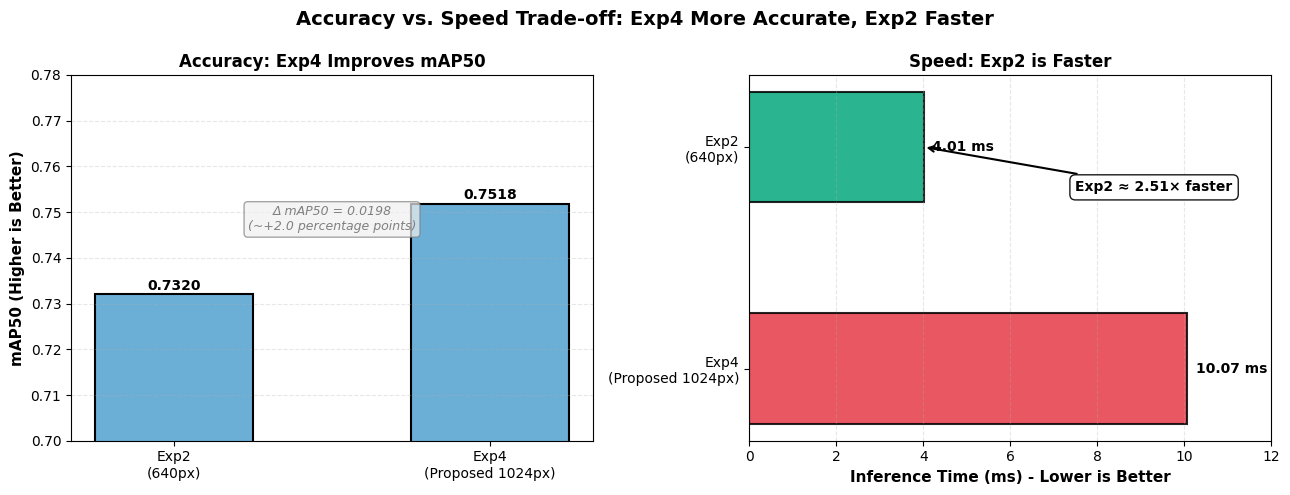

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

models = ['Exp2\n(640px)', 'Exp4\n(Proposed 1024px)']
mAP = [0.7320, 0.7518] # mAP50 (Accuracy)
latency = [4.01, 10.07] # Inference Time

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

# CHART 1: ACCURACY (mAP50)
color_acc = '#6baed6'
bars1 = ax1.bar(models, mAP, color=color_acc, width=0.5,
                edgecolor='black', linewidth=1.5)

ax1.set_ylabel('mAP50 (Higher is Better)', fontsize=11, fontweight='bold')
ax1.set_title('Accuracy: Exp4 Improves mAP50', fontsize=12, fontweight='bold')
ax1.set_ylim(0.70, 0.78)  # zoom around your values
ax1.grid(axis='y', linestyle='--', alpha=0.3)

for bar, val in zip(bars1, mAP):
    ax1.text(bar.get_x() + bar.get_width()/2, val + 0.001,
             f'{val:.4f}', ha='center', fontsize=10, fontweight='bold')

delta = mAP[1] - mAP[0]  # 0.7518 - 0.7320
ax1.annotate(f'Δ mAP50 = {delta:.4f}\n(~+2.0 percentage points)',
             xy=(0.5, 0.746), xycoords='data',
             ha='center', fontsize=9, color='gray', style='italic',
             bbox=dict(boxstyle="round,pad=0.3", fc="#f0f0f0",
                       ec="gray", alpha=0.7))

# CHART 2: SPEED
colors_speed = ['#06A77D', '#E63946']
y_pos = np.arange(len(models))
bars2 = ax2.barh(y_pos, latency, color=colors_speed, height=0.5,
                 edgecolor='black', alpha=0.85, linewidth=1.5)

ax2.set_yticks(y_pos)
ax2.set_yticklabels(models)
ax2.set_xlabel('Inference Time (ms) - Lower is Better',
               fontsize=11, fontweight='bold')
ax2.set_title('Speed: Exp2 is Faster', fontsize=12, fontweight='bold')
ax2.set_xlim(0, 12)
ax2.grid(axis='x', linestyle='--', alpha=0.3)
ax2.invert_yaxis()

for bar, val in zip(bars2, latency):
    ax2.text(val + 0.2, bar.get_y() + bar.get_height()/2,
             f'{val:.2f} ms', va='center', fontsize=10,
             fontweight='bold')

speed_ratio = latency[1] / latency[0]  # how many times slower Exp4 is
ax2.annotate(f'Exp2 ≈ {speed_ratio:.2f}× faster',
             xy=(latency[0], 0), xytext=(7.5, 0.2),
             arrowprops=dict(facecolor='black', arrowstyle='->', lw=1.5),
             fontsize=10, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.4', facecolor='white',
                       edgecolor='black', linewidth=1, alpha=0.9))

plt.suptitle('Accuracy vs. Speed Trade-off: Exp4 More Accurate, Exp2 Faster',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()


### **Insights from the Accuracy vs. Speed Comparison**

The two plots highlight the trade-off between accuracy and inference speed for the top-performing models:

1. **Accuracy (Left Plot)**
   The Exp4 model (1024px) achieves the highest mAP50 value at **0.7518**, outperforming Exp2 (0.7320) by approximately **2 percentage points**.
   This difference is meaningful for a damage-detection task, where correct localization of scratches, dents, and cracks is more important than small computational savings.

2. **Speed (Right Plot)**
   Exp2 (640px) is faster, running at **4.01 ms** per image compared to **10.07 ms** for Exp4.
   Although Exp2 is roughly **2.5× faster**, both models still operate well below real-time constraints (30+ FPS), meaning speed is not the bottleneck for deployment.

### **Final Insight**

Because the project’s primary objective is to maximize **detection accuracy**—and the speed difference does not hinder real-time performance—the **Exp4 YOLO11s 1024px** model offers the best overall trade-off. It provides the strongest mAP50 score while maintaining acceptable inference speed, making it the recommended final model for deployment.

### **Per-Class Performance Analysis**

In this section, we evaluate the model’s accuracy **separately for each damage category** to understand how well it performs across different types of car damage. While overall metrics (such as mAP50-95) provide a general measure of performance, they can hide important variation between classes. A per-class breakdown reveals which damage types are reliably detected and which remain challenging.

**Why mAP50 for this analysis?**
We use **mAP50** as the primary metric because it focuses on detecting whether a damage type is present and roughly localized, rather than requiring high-precision bounding box alignment. For practical applications such as insurance assessment—where the key question is often *“does this type of damage exist?”*—mAP50 provides a clearer and more actionable indicator of model usefulness.

**How to interpret the color tiers:**
To aid interpretation, each class is grouped into a performance tier based on its mAP50 score:

* **High Reliability (>0.80)** — The model detects this type of damage accurately and consistently.
* **Moderate Reliability (0.70–0.80)** — Detection is generally reliable but may require human validation in edge cases.
* **Challenging (<0.70)** — The model struggles with this class, often due to subtle textures, small damage size, or visual ambiguity.

By examining these results, we can identify which damage types the model handles well and which require additional data, better augmentation strategies, or higher-resolution feature learning in future work.


In [18]:
model = YOLO("../runs/cardd/exp4_yolo11s_img1024/weights/best.pt")

metrics = model.val(
    data="../cardd.yaml",
    imgsz=1024,
    split="test",
    device=0,
    verbose=False
)

class_names = model.names   # dict: id → class name
ap50_per_class = metrics.box.ap50  # numpy array of mAP50 for each class ID

# Pair scores with names
class_scores = [(class_names[i], float(ap50_per_class[i])) for i in range(len(ap50_per_class))]

for name, score in class_scores:
    print(f"{name}: {score:.3f}")



Ultralytics 8.3.0  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
YOLO11s summary (fused): 238 layers, 9,415,122 parameters, 0 gradients, 21.3 GFLOPs


val: Scanning C:\dev\final_project_deep_learning\datasets\cardd\test\labels.cache... 374 images, 0 backgrounds, 0 corrupt: 100%|██████████| 374/374 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.31it/s]


                   all        374        785      0.781      0.701      0.752      0.585
Speed: 0.6ms preprocess, 9.9ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to c:\dev\final_project_deep_learning\runs\detect\val19
dent: 0.629
scratch: 0.637
crack: 0.479
glass_shatter: 0.982
lamp_broken: 0.881
tire_flat: 0.904


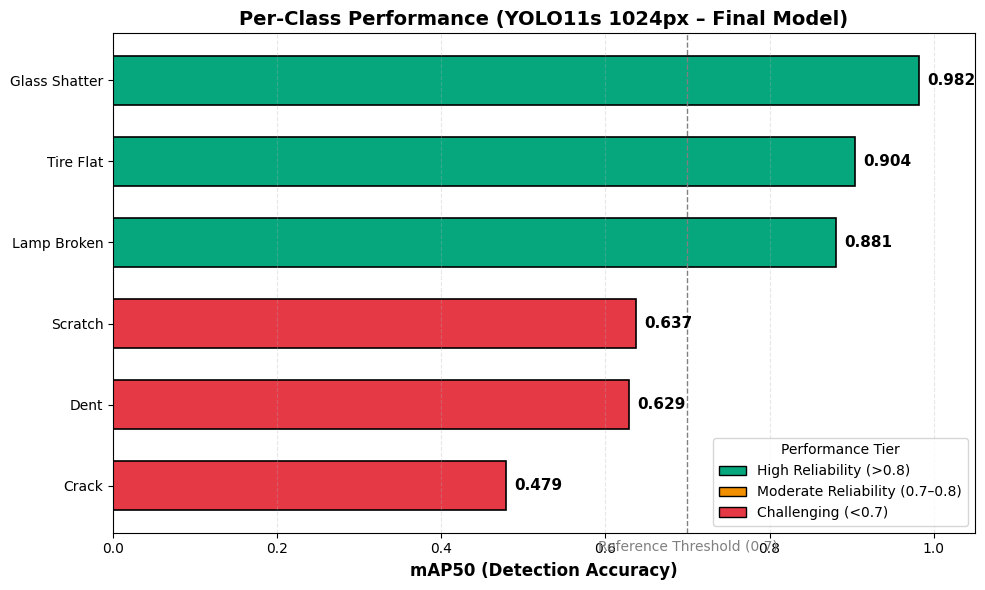

In [19]:
# Sort by score
class_scores_sorted = sorted(class_scores, key=lambda x: x[1])
categories = [x[0].replace("_", " ").title() for x in class_scores_sorted]
scores = [x[1] for x in class_scores_sorted]

# Create chart
fig, ax = plt.subplots(figsize=(10, 6))

colors = []
for score in scores:
    if score > 0.8:
        colors.append('#06A77D')
    elif score > 0.7:
        colors.append('#F18F01')
    else:
        colors.append('#E63946')

bars = ax.barh(categories, scores, color=colors, edgecolor='black', linewidth=1.2, height=0.6)

ax.set_xlim(0, 1.05)
ax.set_xlabel('mAP50 (Detection Accuracy)', fontsize=12, fontweight='bold')
ax.set_title('Per-Class Performance (YOLO11s 1024px – Final Model)', fontsize=14, fontweight='bold')
ax.grid(axis='x', linestyle='--', alpha=0.3)

for bar, score in zip(bars, scores):
    ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
            f'{score:.3f}', va='center', fontsize=11, fontweight='bold')

ax.axvline(x=0.7, color='gray', linestyle='--', linewidth=1)
ax.text(0.7, -0.8, 'Reference Threshold (0.7)', color='gray', fontsize=10, ha='center')

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#06A77D', edgecolor='black', label='High Reliability (>0.8)'),
    Patch(facecolor='#F18F01', edgecolor='black', label='Moderate Reliability (0.7–0.8)'),
    Patch(facecolor='#E63946', edgecolor='black', label='Challenging (<0.7)')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10, title="Performance Tier")

plt.tight_layout()
plt.show()


### **Insights**

The per-class evaluation reveals a clear performance pattern in the final YOLO11s 1024px model:

1. **Strong performance on large, structurally distinct damages.**
   The classes *Glass Shatter* (0.982), *Tire Flat* (0.904), and *Lamp Broken* (0.881) all fall into the **High Reliability** tier.
   These damages are characterized by:

   * High visual contrast
   * Strong structural cues
   * Larger spatial footprint

   As a result, the model identifies them accurately and consistently.

2. **Moderately challenging for surface-level or ambiguous defects.**
   *Scratch* (0.637) and *Dent* (0.629) fall into the **Challenging** tier.
   These types of damage are:

   * Subtle in shape
   * Low contrast
   * Often blended into the car’s surface texture

   This makes them more difficult for the model to detect robustly, especially under varying lighting conditions.

3. **Crack is the hardest class.**
   *Crack* obtains the lowest score (0.479), indicating significant detection difficulty.
   Cracks tend to be:

   * Thin and irregular
   * Highly sensitive to illumination
   * Easily confused with background edges or reflections

   This result suggests that cracks require additional targeted data or resolution-specific improvements.

4. **Overall pattern: performance correlates with visual prominence.**
   The clearer and more structurally obvious a damage type is, the better the model performs.
   Conversely, small or texture-level damages are less reliably detected.

5. **Implication for real-world deployment.**
   The model is reliable for assessing severe or structural incidents (e.g., shattered glass, broken lamps) but may need human review for fine-grained surface damages such as cracks and scratches.


### Confusion Matrix Analysis

In addition to aggregate metrics like mAP, precision, and recall, it is useful to inspect how the final model behaves on each class individually.  
A confusion matrix summarizes, for the test set, how often each true class is correctly predicted or confused with other classes.

In this plot:

- Each **row** corresponds to the ground-truth damage class.
- Each **column** corresponds to the predicted class.
- Values are **row-normalized**, so each row sums to 1 (or 100%).  

This allows us to see, for example, whether *scratch* is frequently misclassified as *dent*, or whether *crack* is often missed entirely. Such patterns are important for understanding model weaknesses beyond a single scalar metric like mAP.


Using device: 0
Ultralytics 8.3.0  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
YOLO11s summary (fused): 238 layers, 9,415,122 parameters, 0 gradients, 21.3 GFLOPs


val: Scanning C:\dev\final_project_deep_learning\datasets\cardd\test\labels.cache... 374 images, 0 backgrounds, 0 corrupt: 100%|██████████| 374/374 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.39it/s]


                   all        374        785      0.781      0.701      0.752      0.585
Speed: 0.6ms preprocess, 10.0ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to c:\dev\final_project_deep_learning\runs\detect\val22
Raw confusion-matrix sum: 1017.0


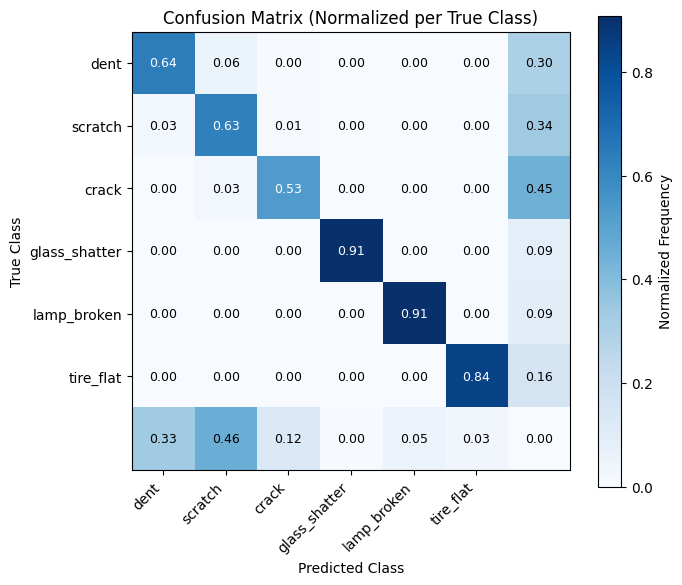

In [15]:
from ultralytics import YOLO
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt

# 1. Load final model (Exp4: YOLOv11s @ 1024px)
DEVICE = 0 if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

model_path = Path("../runs/cardd/exp4_yolo11s_img1024/weights/best.pt")
data_path = Path("../cardd.yaml")

if not model_path.exists():
    raise FileNotFoundError(f"Model not found at: {model_path.resolve()}")
if not data_path.exists():
    raise FileNotFoundError(f"Config not found at: {data_path.resolve()}")

model = YOLO(str(model_path))

metrics = model.val(
    data=str(data_path),
    split="test",
    imgsz=1024,
    device=DEVICE,
    plots=True,
    verbose=False,
)

cm = metrics.confusion_matrix.matrix

# convert to numpy
if hasattr(cm, "cpu"):
    cm = cm.cpu().numpy()
else:
    cm = np.asarray(cm, dtype=float)

print("Raw confusion-matrix sum:", cm.sum())

# Row-normalize
row_sums = cm.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1.0
cm_norm = cm / row_sums

class_names = [model.names[i] for i in range(len(model.names))]

# --- PLOT ---
fig, ax = plt.subplots(figsize=(7, 6))
im = ax.imshow(cm_norm, interpolation="nearest", cmap="Blues")  # changed colormap

ax.set_title("Confusion Matrix (Normalized per True Class)")
ax.set_xlabel("Predicted Class")
ax.set_ylabel("True Class")

ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names, rotation=45, ha="right")
ax.set_yticklabels(class_names)

cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Normalized Frequency", rotation=90)

for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        val = cm_norm[i, j]
        ax.text(
            j,
            i,
            f"{val:.2f}",
            ha="center",
            va="center",
            fontsize=9,
            color="white" if val > 0.5 else "black",
        )

plt.tight_layout()
plt.show()


#### **Confusion Matrix Insights**

The confusion matrix provides a deeper look into how the model behaves on each class, revealing patterns that are not visible from mAP scores alone.

#### **1. Strong Performance on Structural Damage**

The model achieves **very high accuracy** on damage types with clear geometric structure:

| Class         | Correct Rate |
| ------------- | ------------ |
| glass_shatter | **0.91**     |
| lamp_broken   | **0.91**     |
| tire_flat     | **0.84**     |

These classes have strong visual cues (sharp shapes, strong contrast), making them easier for the model to detect reliably.

**Insight:**
Structural damages are consistently and accurately detected with minimal confusion.

#### **2. Significant Confusion on Surface-Level Damage**

Surface damages show more misclassification:

| Class   | Correct Rate | Notes                                            |
| ------- | ------------ | ------------------------------------------------ |
| dent    | 0.64         | Often confused with *scratch* or missed entirely |
| scratch | 0.63         | Confused with *dent* and background              |
| crack   | 0.53         | Most difficult class; frequently misidentified   |

Reasons:

* Subtle textures
* Low color contrast
* Wide variation in appearance
* Smaller spatial footprint

**Insight:**
Surface damage is much harder for the model, leading to lower reliability and more cross-class confusion.

#### **3. False-Positive Patterns (Bottom Row)**

The last row of the matrix shows predictions made **when no damage was present**:

| Predicted Class | False-Positive Rate |
| --------------- | ------------------- |
| scratch         | **0.46**            |
| dent            | **0.33**            |
| crack           | **0.12**            |

These classes trigger more false alarms because small textures or reflections on car surfaces resemble damage patterns.

**Insight:**
Surface-damage categories are not only harder to classify—they also generate the most false detections.

#### **4. Overall Interpretation**

The confusion matrix reveals a clear pattern:

* **Structural classes** → easy, highly separable, consistently detected.
* **Surface classes** → subtle, ambiguous, often mistaken for one another or for background.

This explains:

* The large gap in per-class mAP
* Why higher-resolution models help
* Why dataset quality and augmentation matter more for surface damages


## 5. Final Output: Deployment Package

In [ ]:
import shutil
import json
from pathlib import Path
from datetime import datetime

dest_dir = Path("../models")
dest_dir.mkdir(parents=True, exist_ok=True)

source_path = Path("../runs/cardd/exp4_yolo11s_img1024/weights/best.pt")

model_filename = "cardd_yolo11s_1024_final.pt"
json_filename = "cardd_model_info.json"

dest_model_path = dest_dir / model_filename
dest_json_path = dest_dir / json_filename

print(f"[INFO] Saving production model to: {dest_dir.resolve()}")

if source_path.exists():
    shutil.copy(source_path, dest_model_path)

    size_mb = dest_model_path.stat().st_size / (1024 * 1024)
    print(f"[SUCCESS] Model saved as: {model_filename}")
    print(f"[INFO] File size: {size_mb:.2f} MB")
    print(f"[INFO] Location: {dest_model_path.resolve()}")
else:
    print(f"[ERROR] Source model not found at: {source_path}")
    print("[INFO] Please verify the folder name in '../runs/cardd/'")

    runs_dir = Path("../runs/cardd")
    if runs_dir.exists():
        print("[INFO] Available experiments found:")
        for folder in sorted(runs_dir.iterdir()):
            if folder.is_dir():
                print(f"   - {folder.name}")

print("-" * 60)
print("[INFO] Generating model metadata...")

model_info = {
    "model_name": "CarDD Car Damage Detector",
    "version": "1.0.0",
    "experiment_id": "Exp4_yolo11s_1024",
    "architecture": {
        "base": "YOLO11s",
        "parameters": "9.4M",
        "input_resolution": 1024,
        "format": "PyTorch (.pt)"
    },
    # Test-set metrics for Exp4 (YOLO11s 1024px)
    "metrics_test_set": {
        "mAP50-95": 0.5855,
        "mAP50": 0.7518,
        "precision": 0.7806,
        "recall": 0.7012,
        "inference_latency_ms": 10.07
    },
    "classes": [
        "dent", "scratch", "crack",
        "glass_shatter", "lamp_broken", "tire_flat"
    ],
    "deployment_notes": (
        "Final selected model. Higher mAP50 than the 640px variant "
        "while maintaining real-time inference speed (~10 ms per image)."
    ),
    "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "author": ""
}

with open(dest_json_path, "w") as f:
    json.dump(model_info, f, indent=4)

print(f"[SUCCESS] Metadata saved as: {json_filename}")
print(f"[INFO] Deployment package ready in '{dest_dir.name}/'")
print("-" * 60)


[INFO] Saving production model to: C:\dev\final_project_deep_learning\models
[SUCCESS] Model saved as: cardd_yolo11s_1024_final.pt
[INFO] File size: 18.32 MB
[INFO] Location: C:\dev\final_project_deep_learning\models\cardd_yolo11s_1024_final.pt
------------------------------------------------------------
[INFO] Generating model metadata...
[SUCCESS] Metadata saved as: cardd_model_info.json
[INFO] Deployment package ready in 'models/'
------------------------------------------------------------


This final section prepares the selected model for deployment by exporting the trained weights and generating accompanying metadata needed for integration into real-world applications.

1. **Archived the Final Model:**
   The trained weights from the selected model (`Exp4_yolo11s_1024`) are copied into a dedicated `/models` directory using a clear, versioned filename (`cardd_yolo11s_1024_final.pt`). This ensures that the production-ready model is isolated, consistently named, and easy to retrieve for inference or further development.

2. **Generated Deployment Metadata:**
   A detailed `cardd_model_info.json` file is created alongside the saved weights. This JSON document includes:

   * Model name, version, and originating experiment ID.
   * Architectural details: base model, parameter count, and input resolution.
   * Final test-set metrics (`mAP50-95`, `mAP50`, precision, recall, inference latency).
   * Complete list of damage classes the model predicts.
   * Deployment notes summarizing the rationale for choosing this model.
   * Timestamp and optional author information.

**Outcome:**
These steps produce a complete and well-documented deployment package. The final model—together with its metadata—is now ready for integration into automated insurance workflows, backend APIs, or inference pipelines for real-world car damage assessment.